In [263]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import jax
from jax import numpy as np
import numpy as onp
from matplotlib import pyplot as plt
import matplotlib as mpl
from jax import vmap, jit
import time
from jax.config import config
from typing import Callable, Tuple
from functools import partial
config.update("jax_enable_x64", True)
key = jax.random.PRNGKey(42)


import torch
from torchvision import datasets, transforms
import torchvision

import math


mpl.rcParams['axes.grid']           = True
mpl.rcParams['axes.grid.which']     = 'both'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['grid.color']          = '0.8'
mpl.rcParams['grid.alpha']          = '0.5'
mpl.rcParams['figure.figsize']      = (8, 4)
mpl.rcParams['figure.titlesize']    = 10
mpl.rcParams['font.size']           = 10
mpl.rcParams['legend.fontsize']     = 10
mpl.rcParams['figure.dpi']          = 300
mpl.rcParams['font.family']         = 'serif'
mpl.rcParams['text.usetex']         = False

# Visualization

In [2]:
def visualize_grid(skip: int,  imgs: np.ndarray):
    normed_imgs = list(torch.tensor(onp.array(vmap(restore)(imgs))))[::skip]
    norm_grid = torchvision.utils.make_grid([normed_img.permute(2, 0, 1) for normed_img in normed_imgs])
    fig = plt.figure(figsize=(30,12))
    plt.imshow(norm_grid.permute(1, 2, 0))
    plt.xticks([]); plt.yticks([])


def visualize_traj(skip: int,  traj: np.ndarray):
    normed_traj = list(torch.tensor(onp.array(vmap(restore)(traj))))[::skip]
    norm_grid = torchvision.utils.make_grid([normed_x[0].permute(2, 0, 1) for normed_x in normed_traj])
    fig = plt.figure(figsize=(30,12))
    plt.imshow(norm_grid.permute(1, 2, 0))
    plt.xticks([]); plt.yticks([])

# One-Sided

In [3]:
def rho(x: np.ndarray):
    return np.exp(-np.sum(x**2)/2)


@partial(jit, static_argnums=(3, 4, 5, 6, 7))
def eval_drifts(
    t: float,
    x: np.ndarray,
    x0s: np.ndarray,
    alpha: Callable[[float], float],
    beta: Callable[[float], float],
    alpha_dot: Callable[[float], float],
    beta_dot: Callable[[float], float],
    bb_dot: Callable[[float], float]
) -> Tuple[np.ndarray, np.ndarray]:
    args  = vmap(lambda x0: -np.sum(((x - alpha(t)*x0) / beta(t))**2))(x0s)
    args  = args - np.max(args)
    gfacs = np.exp(args/2)
    gfacs = gfacs / np.mean(gfacs)
    u     = np.mean(vmap(lambda x0, gfac: x0*gfac)(x0s, gfacs), axis=0)
    s     = -(x - alpha(t)*u) / beta(t)**2
    b     = alpha_dot(t)*u - bb_dot(t)*s
    
    return b, s, u, args


batch_eval_drifts = vmap(eval_drifts, in_axes=(None, 0, None, None, None, None, None, None))

## N(0, 1) to Mixture

In [11]:
nsteps    = int(1e2)
t0        = 0
tf        = 1.0
dt        = (tf - t0) / nsteps
a         = 1.0
alpha     = lambda t: t
alpha_dot = lambda t: 1.0
beta      = lambda t: np.sqrt(a*(1-t))
beta_dot  = lambda t: -0.5*np.sqrt(a/(1-t))
bb_dot    = lambda t: -0.5*a
eps       = 0.0
sample_bs = 10000
target_bs = 10000
d         = 1
p1        = 0.4
p2        = 0.6
mu1       = np.array([3])
mu2       = np.array([-3])
nprints   = 10


def sample_base(n_samples: int):
    return onp.random.randn(n_samples, d)


def sample_target(n_samples: int):
    ps      = onp.random.uniform(size=(n_samples,))
    samples = onp.random.randn(n_samples, d)
    samples[ps < p1] += mu1
    samples[ps > p1] += mu2
    return samples
 

xs_traj    = onp.zeros((nsteps+1, sample_bs, d))
xs         = sample_base(sample_bs)
xs_traj[0] = onp.array(xs)


start_time = time.time()
for curr_step in range(nsteps):
    # set up current time
    t = t0 + (curr_step + 0.5)*dt


    # sample from the target and draw noises for the SDE
    x0s     = sample_target(target_bs)
    key     = jax.random.split(key)[0]
    noises  = jax.random.normal(key, shape=xs.shape)
    
    
    # take a step
    bs, scores           = batch_eval_drifts(t, xs, x0s, alpha, beta, alpha_dot, beta_dot, bb_dot)
    xs                   = xs + dt*(bs + eps*scores) + np.sqrt(2*eps*dt)*noises
    xs_traj[curr_step+1] = onp.array(xs)


    if (curr_step + 1) % (nsteps // nprints) == 0:
        end_time = time.time()
        print(f'Finished step={curr_step+1}. Time={end_time-start_time}s. t={t}.')
        start_time = time.time()

Finished step=10. Time=1.7968835830688477s. t=0.095.
Finished step=20. Time=1.2980523109436035s. t=0.195.
Finished step=30. Time=1.2712047100067139s. t=0.295.
Finished step=40. Time=1.0324242115020752s. t=0.395.
Finished step=50. Time=1.0204262733459473s. t=0.495.
Finished step=60. Time=1.1182479858398438s. t=0.595.
Finished step=70. Time=1.36354398727417s. t=0.6950000000000001.
Finished step=80. Time=0.9212298393249512s. t=0.795.
Finished step=90. Time=0.883145809173584s. t=0.895.
Finished step=100. Time=1.1124720573425293s. t=0.995.


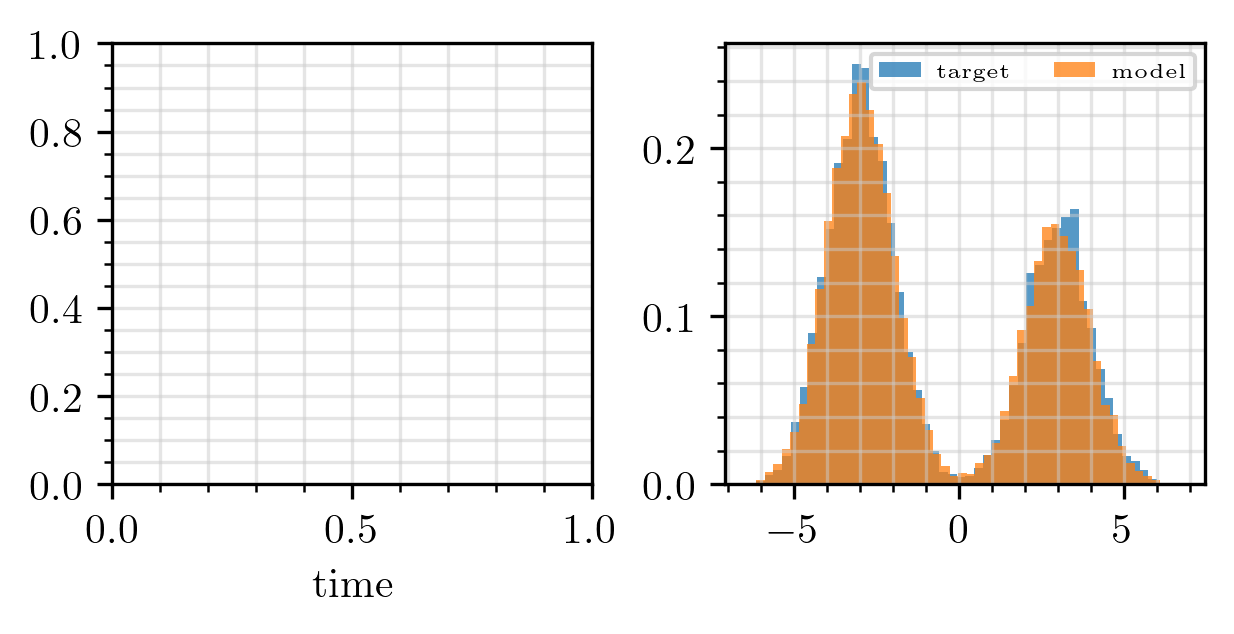

In [12]:
plt.close('all')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), constrained_layout=True)
ts       = onp.linspace(t0, tf, nsteps+1)


# axs[0].plot(ts, onp.squeeze(xs_traj), alpha=0.5, lw=0.25)
axs[0].set_xlabel('time')
_ = axs[1].hist(onp.array(sample_target(sample_bs)), bins=50, alpha=0.75, label='target', density=True)
_ = axs[1].hist(onp.array(onp.squeeze(xs)), bins=50, alpha=0.75,  label='model', density=True)
axs[1].legend(ncol=2, fontsize=5.0)

## Images

In [124]:
def rescale(img: torch.tensor) -> onp.ndarray:
    return (onp.array(img) / 255.0)*2 - 1


def restore(img: np.ndarray):
    return (img + 1.0) / 2.0


train_bs = 128
trainset = datasets.MNIST('/mnt/ceph/users/malbergo/data/', download=True, train=True, transform=rescale)


train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=train_bs,
    shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(([], []), ([], []))

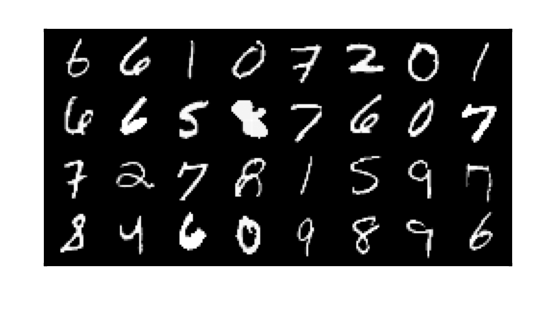

In [90]:
### check that it actually shuffles
# plt.figure(figsize=(2,10))
# plt.imshow(torchvision.utils.make_grid(next(iter(train_loader))[0].unsqueeze(1)).permute(1,2,0))
# plt.xticks([]), plt.yticks([])

### Implementation for annealing from some t*

In [17]:
xt = lambda t, x0, z: alpha(t)*x0 + beta(t)*z
x0 = np.array(next(iter(train_loader))[0])[0]

A :  3.0


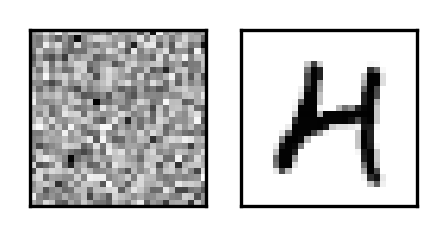

Finished step=100. Time=3.059936046600342s. t=0.10000000000000007.


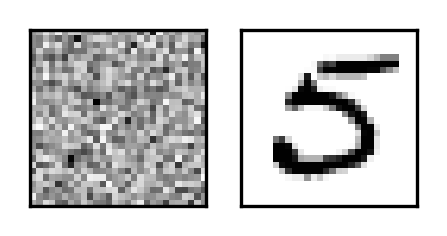

Finished step=200. Time=2.900956153869629s. t=0.20000000000000015.


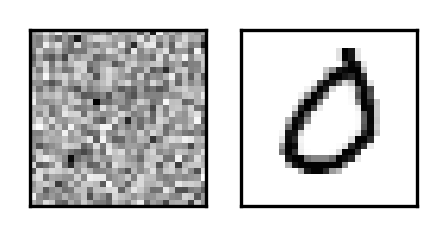

Finished step=300. Time=2.844771146774292s. t=0.3000000000000002.


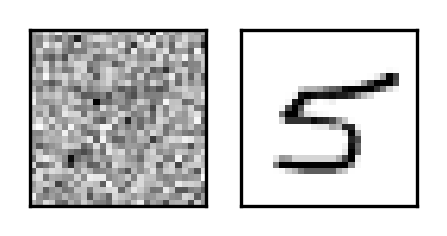

Finished step=400. Time=2.6673922538757324s. t=0.4000000000000003.


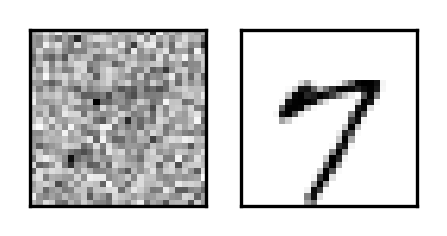

Finished step=500. Time=2.73785400390625s. t=0.5000000000000003.


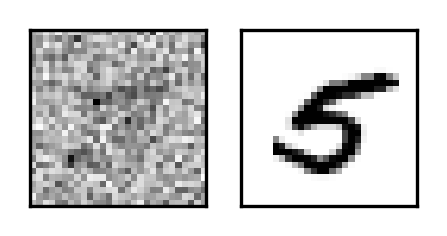

Finished step=600. Time=2.878638505935669s. t=0.6000000000000004.


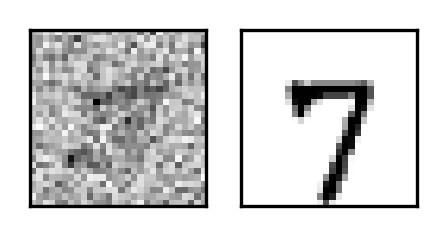

Finished step=700. Time=2.844069719314575s. t=0.7000000000000005.


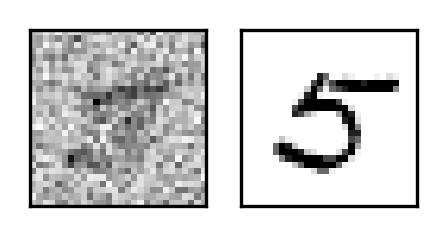

Finished step=800. Time=2.854400873184204s. t=0.8000000000000006.


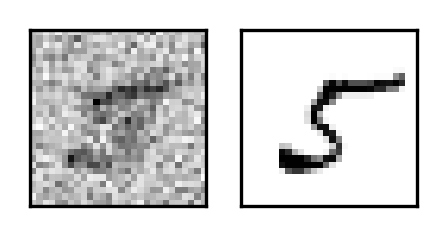

Finished step=900. Time=3.016979455947876s. t=0.9000000000000007.


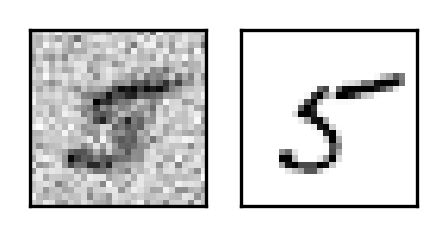

Finished step=1000. Time=2.8280279636383057s. t=0.9896432189714318.


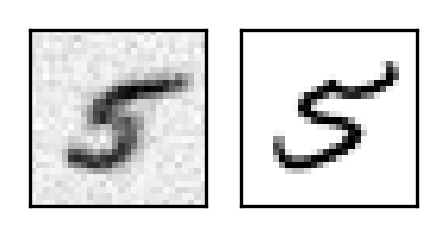

1000 0.9897932189714318
Finished step=1100. Time=2.879427909851074s. t=0.9950816048620608.


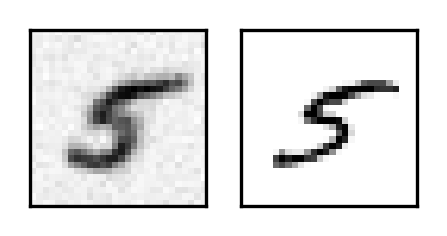

1100 0.9951066048620608
Finished step=1200. Time=3.020897388458252s. t=0.9969057062866655.


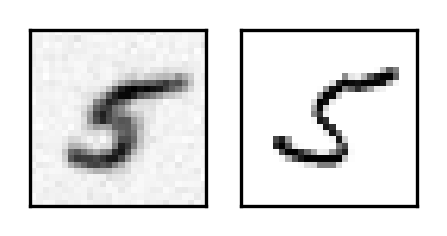

1200 0.9969193426503019
Finished step=1300. Time=2.8282358646392822s. t=0.9980319200406828.


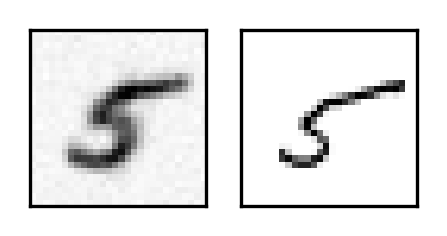

1300 0.9980412950406827
Finished step=1400. Time=2.8262999057769775s. t=0.9988488382827333.


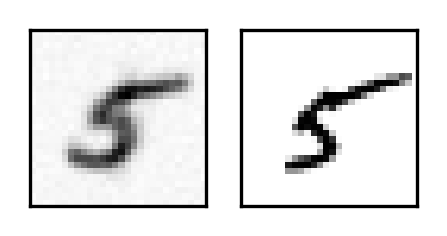

1400 0.9988559811398762
Finished step=1500. Time=2.8399243354797363s. t=0.9994902478894907.


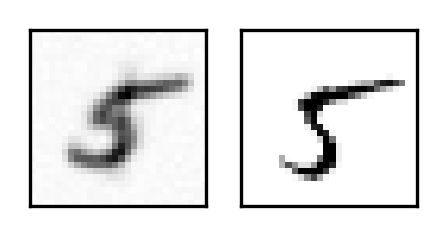

1500 0.9994960171202599


In [274]:
# sampling settings
max_steps  = int(1e4)
init_steps = int(1e3)
delta      = 0
t0         = 0.0
tf         = 1.0 - delta
dt0        = (tf - t0) / init_steps
a          = 1.0
alpha      = lambda t: t
alpha_dot  = lambda t: 1.0
nu         = 0.5
beta       = lambda t: (a*(1-t))**nu
beta_dot   = lambda t: -a*nu*(a*(1-t))**(nu-1)
bb_dot     = lambda t: -a*nu*(a - a*t)**(2*nu-1)
xt         = lambda t, x0, z: alpha(t)*x0 + beta(t)*z
eps        = 0.0
nprints    = 10
sample_bs  = 1
shape      = np.array(next(iter(train_loader))[0]).shape[1:]
fixed_dataset = False
regularize = False
cap = 750

T         = 0.98
n_star    = T / dt0
p         = 1.0
anneal    = True
dt        = dt0
A_max     = 6*(1 - T) / (math.pi**2 *dt0)### for p = 2
A         = 3.0
print("A : ", A)


# save trajectories
xs_traj    = []
xs         = np.array(onp.random.randn(sample_bs, *shape))
xs_traj.append(onp.array(xs))
score_traj = []
b_traj     = []
x0s_traj   = []
x0s        = np.array(next(iter(train_loader))[0])
gfacs_traj = []



# visualize image trajectories
plt.close('all')
plot_bs = 1
ncols   = 2
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*250/300, 250/300))
for kk, ax in enumerate(axs):
    if kk == 0:
        axs[kk].imshow(restore(xs[kk] / np.abs(xs[kk]).max()), cmap="Greys")
    else:
        dists = vmap(lambda x0: np.sum((xs[0] - x0)**2))(x0s)
        min_index = np.argmin(dists)
        axs[kk].imshow(restore(x0s[min_index]), cmap="Greys")
    ax.grid(False)
    ax.tick_params(which='both', bottom=False, left=False)
    ax.set_xticks([]); ax.set_yticks([])
plt.pause(0.001)


start_time = time.time()
curr_step = 0 
t = t0 #+ dt/2
while t < 0.999999:
    # set up current time
    t+=dt


    # sample from the target and draw noises for the SDE
    if not fixed_dataset:
        x0s    = np.array(next(iter(train_loader))[0])

    key    = jax.random.split(key)[0]
    noises = jax.random.normal(key, shape)
    
    # take a step
    if anneal:
        if curr_step <= n_star:
            dt = dt0
        else:
            
            ## printing
            if curr_step % 100 == 0:
                print(curr_step, t)
            # dt = dt0*(n_star/curr_step)**p
            dt = A*dt0*(1/(curr_step - n_star + 1))**p

    bs, scores, us, gfacs = batch_eval_drifts(t, xs, x0s, alpha, beta, alpha_dot, beta_dot, bb_dot)
    expt                  = np.exp(dt*beta_dot(t) / beta(t))
    iexpt                 = (expt - 1)*beta(t) / beta_dot(t)
    siexpt                = 0.5*(expt**2 - 1)*beta(t) / beta_dot(t)
    if regularize:
        b_norm            = np.sqrt(np.sum(bs**2))
        if b_norm > cap:
            bs                = bs*cap/ (b_norm)
    # xs                    = xs*expt + iexpt*us*(alpha_dot(t) - alpha(t)*beta_dot(t)/beta(t)) + iexpt*eps*scores + np.sqrt(2*eps*siexpt)*noises
    xs             = xs + dt*(bs + eps*scores) + np.sqrt(2*eps*dt)*noises

    
    # save trajectories
    x0s_traj.append(onp.array(x0s))
    xs_traj.append(onp.array(xs))
    score_traj.append(onp.array(scores))
    b_traj.append(onp.array(bs + eps*scores))
    gfacs_traj.append(onp.array(onp.squeeze(gfacs)))


    if (curr_step + 1) % (init_steps // nprints) == 0:
        end_time = time.time()
        print(f'Finished step={curr_step+1}. Time={end_time-start_time}s. t={t}.')
        start_time = time.time()

        plt.close('all')
        fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*250/300, 250/300))
        for kk, ax in enumerate(axs):
            if kk == 0:
                axs[kk].imshow(restore(xs[kk] / np.abs(xs[kk]).max()), cmap="Greys")
            else:
                dists = vmap(lambda x0: np.sum((xs[0] - x0)**2))(x0s)
                min_index = np.argmin(dists)
                axs[kk].imshow(restore(x0s[min_index]), cmap="Greys")
            ax.grid(False)
            ax.tick_params(which='both', bottom=False, left=False)
            ax.set_xticks([]); ax.set_yticks([])
        plt.pause(0.001)
    
    curr_step += 1

### Just regularize implementation.

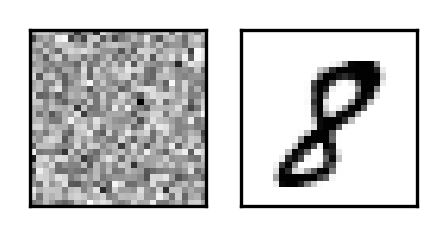

Finished step=100. Time=3.1254279613494873s. t=0.0995.


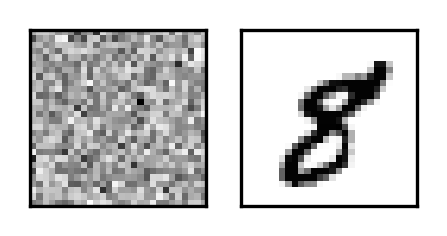

Finished step=200. Time=2.919773578643799s. t=0.1995.


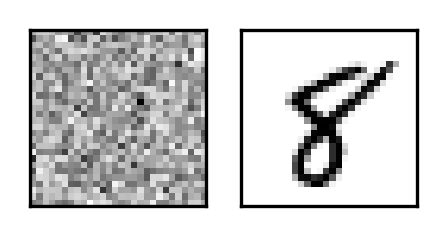

Finished step=300. Time=2.864899158477783s. t=0.2995.


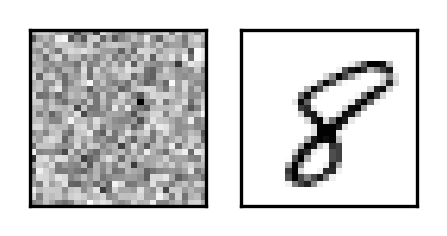

Finished step=400. Time=2.853764772415161s. t=0.3995.


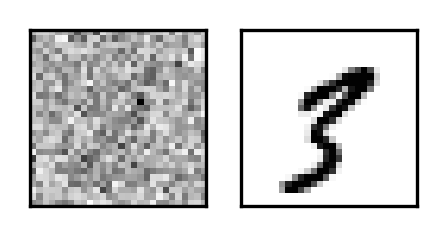

Finished step=500. Time=2.9864516258239746s. t=0.4995.


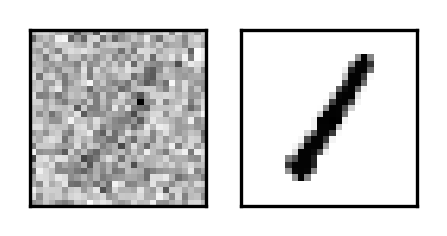

Finished step=600. Time=3.0524773597717285s. t=0.5995.


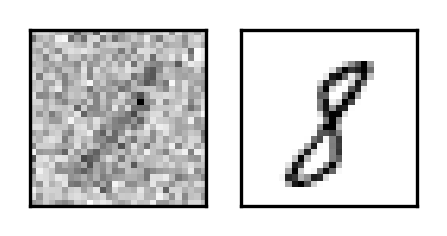

Finished step=700. Time=2.864654302597046s. t=0.6995.


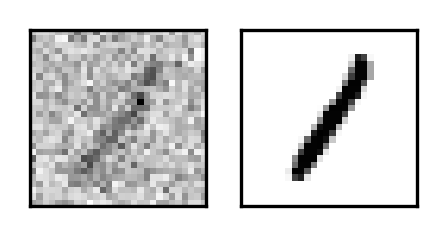

Finished step=800. Time=2.864546060562134s. t=0.7995.


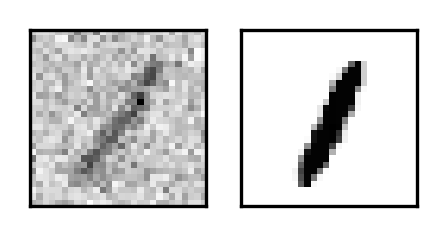

Finished step=900. Time=2.8572094440460205s. t=0.8995.


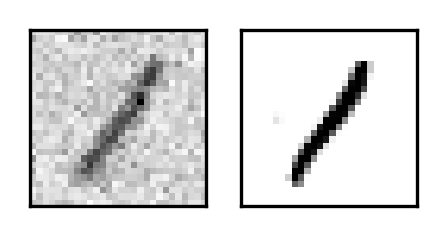

Finished step=1000. Time=2.8210320472717285s. t=0.9995.


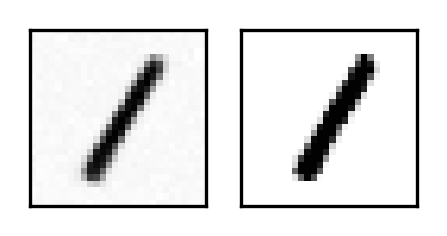

In [278]:
# sampling settings
nsteps    = int(1e3)
delta     = 0
t0        = 0.0
tf        = 1.0 - delta
dt        = (tf - t0) / nsteps
a         = 1.0
alpha     = lambda t: t
alpha_dot = lambda t: 1.0
nu        = 0.5
beta      = lambda t: (a*(1-t))**nu
beta_dot  = lambda t: -a*nu*(a*(1-t))**(nu-1)
bb_dot    = lambda t: -a*nu*(a - a*t)**(2*nu-1)
xt        = lambda t, x0, z: alpha(t)*x0 + beta(t)*z
eps       = 0.0
nprints   = 10
sample_bs = 1
shape     = np.array(next(iter(train_loader))[0]).shape[1:]
fixed_dataset = False
regularize = True
cap = 750

# save trajectories
xs_traj    = onp.zeros((nsteps+1, sample_bs) + shape)
xs         = np.array(onp.random.randn(sample_bs, *shape))
xs_traj[0] = onp.array(xs)
score_traj = onp.zeros((nsteps, sample_bs) + shape)
b_traj     = onp.zeros((nsteps, sample_bs) + shape)
x0s_traj   = onp.zeros((nsteps, train_bs) + shape)
x0s        = np.array(next(iter(train_loader))[0])
gfacs_traj = onp.zeros((nsteps, train_bs))


# visualize image trajectories
plt.close('all')
plot_bs = 1
ncols   = 2
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*250/300, 250/300))
for kk, ax in enumerate(axs):
    if kk == 0:
        axs[kk].imshow(restore(xs[kk] / np.abs(xs[kk]).max()), cmap="Greys")
    else:
        dists = vmap(lambda x0: np.sum((xs[0] - x0)**2))(x0s)
        min_index = np.argmin(dists)
        axs[kk].imshow(restore(x0s[min_index]), cmap="Greys")
    ax.grid(False)
    ax.tick_params(which='both', bottom=False, left=False)
    ax.set_xticks([]); ax.set_yticks([])
plt.pause(0.001)


start_time = time.time()
for curr_step in range(nsteps):
    # set up current time
    t = t0 + (curr_step + 0.5)*dt


    # sample from the target and draw noises for the SDE
    if not fixed_dataset:
        x0s    = np.array(next(iter(train_loader))[0])

    key    = jax.random.split(key)[0]
    noises = jax.random.normal(key, shape)
    
    # # take a step
    # if anneal:
    #     if curr_step <= n_star:
    #         dt = dt0
    #     else:
    #         dt = dt0*(n_star/curr_step)**p
            
    bs, scores, us, gfacs = batch_eval_drifts(t, xs, x0s, alpha, beta, alpha_dot, beta_dot, bb_dot)
    expt                  = np.exp(dt*beta_dot(t) / beta(t))
    iexpt                 = (expt - 1)*beta(t) / beta_dot(t)
    siexpt                = 0.5*(expt**2 - 1)*beta(t) / beta_dot(t)
    if regularize:
        b_norm            = np.sqrt(np.sum(bs**2))
        if b_norm > cap:
            bs                = bs*cap/ (b_norm)
    # xs                    = xs*expt + iexpt*us*(alpha_dot(t) - alpha(t)*beta_dot(t)/beta(t)) + iexpt*eps*scores + np.sqrt(2*eps*siexpt)*noises
    xs             = xs + dt*(bs + eps*scores) + np.sqrt(2*eps*dt)*noises

    
    # save trajectories
    x0s_traj[curr_step]   = onp.array(x0s)
    xs_traj[curr_step+1]  = onp.array(xs)
    score_traj[curr_step] = onp.array(scores)
    b_traj[curr_step]     = onp.array(bs + eps*scores)
    gfacs_traj[curr_step] = onp.array(onp.squeeze(gfacs))


    if (curr_step + 1) % (nsteps // nprints) == 0:
        end_time = time.time()
        print(f'Finished step={curr_step+1}. Time={end_time-start_time}s. t={t}.')
        start_time = time.time()

        plt.close('all')
        fig, axs = plt.subplots(ncols=1+plot_bs, figsize=(ncols*250/300, 250/300))
        for kk, ax in enumerate(axs):
            if kk == 0:
                axs[kk].imshow(restore(xs[kk] / np.abs(xs[kk]).max()), cmap="Greys")
            else:
                dists = vmap(lambda x0: np.sum((xs[0] - x0)**2))(x0s)
                min_index = np.argmin(dists)
                axs[kk].imshow(restore(x0s[min_index]), cmap="Greys")
            ax.grid(False)
            ax.tick_params(which='both', bottom=False, left=False)
            ax.set_xticks([]); ax.set_yticks([])
        plt.pause(0.001)

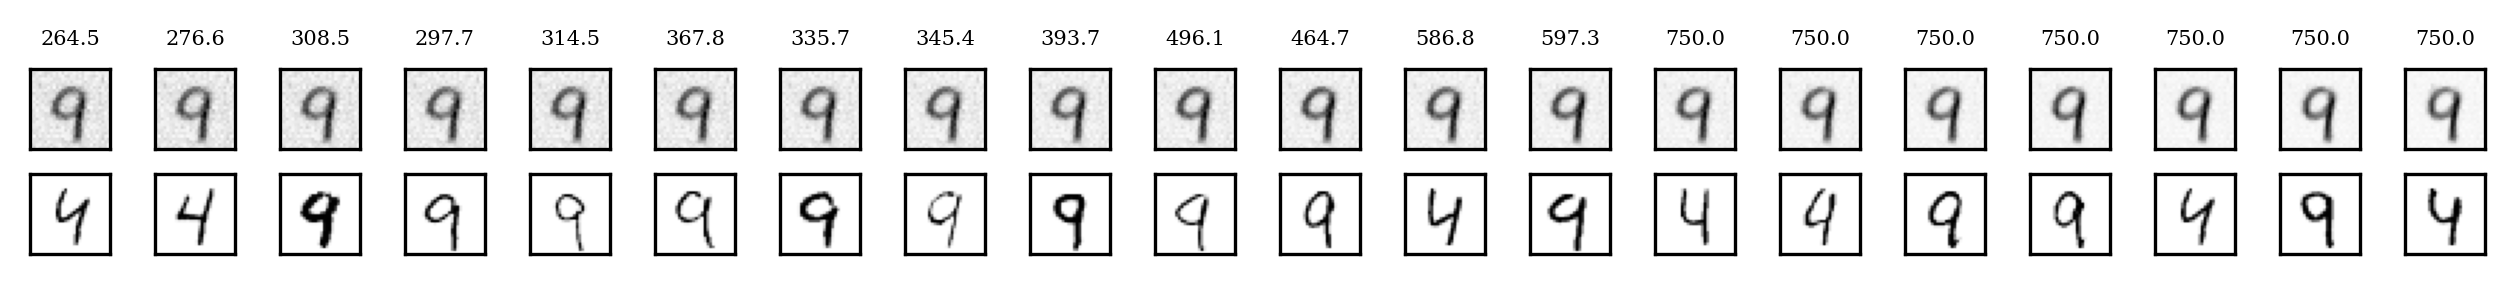

In [185]:
nimgs_plot = 20
start = False
nrows = 2
img_size = 125/300
fig, axs = plt.subplots(nrows=nrows, ncols=nimgs_plot, figsize=(nimgs_plot*img_size, nrows*img_size), constrained_layout=True)

for ii in range(nrows):
    for jj in range(nimgs_plot):
        if start:
            ind = jj
        else:
            ind = -nimgs_plot+jj
            
        ax       = axs[ii, jj]
        img      = xs_traj[ind][0]
        curr_x0s = x0s_traj[ind]
        curr_bs  = b_traj[ind][0]
        

        
        if ii == 0:
            b_norm = np.sqrt(np.sum(curr_bs**2))
            ax.set_title(f'{b_norm:.01f}', fontsize=5)
            ax.imshow(restore(img), cmap='Greys')
        else:
            dists       = vmap(lambda x0: np.sum((img - x0)**2))(curr_x0s)
            min_index   = np.argmin(dists)
            nearest_img = curr_x0s[min_index]
            ax.imshow(restore(nearest_img), cmap='Greys')


        ax.grid(False)
        ax.tick_params(which='both', bottom=False, left=False)
        ax.set_xticks([]); ax.set_yticks([])

In [224]:
1.0 / beta(1-1e-3)**2

Array(1000., dtype=float64, weak_type=True)

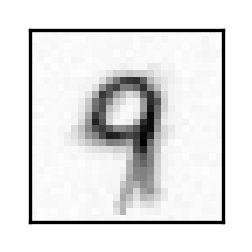

In [127]:
for kk in range(nsteps+1):
    curr_x = xs_traj[kk]
    plt.close('all')
    fig, ax = plt.subplots(figsize=(250/300, 250/300))
    ax.imshow(restore(xs_traj[kk][0]), cmap="Greys")
    ax.grid(False)
    ax.tick_params(which='both', bottom=False, left=False)
    ax.set_xticks([]); ax.set_yticks([])
    plt.savefig(f'/scratch/nb3397/results/interpolant/exact_velocity/movies/fr{kk:04d}.png', dpi=300)

In [138]:
sigma      = 0.008
step_index = 4
denoised   = xs_traj[-step_index, 0] + sigma * score_traj[-step_index, 0]

[]

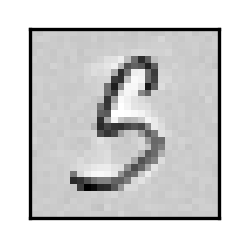

In [139]:
fig, ax = plt.subplots(figsize=(250/300, 250/300))
ax.imshow(denoised, cmap="Greys")
ax.grid(False)
ax.tick_params(which='both', bottom=False, left=False)
ax.set_xticks([]); ax.set_yticks([])

Text(0.5, 1.0, 'true batch size = 10000')

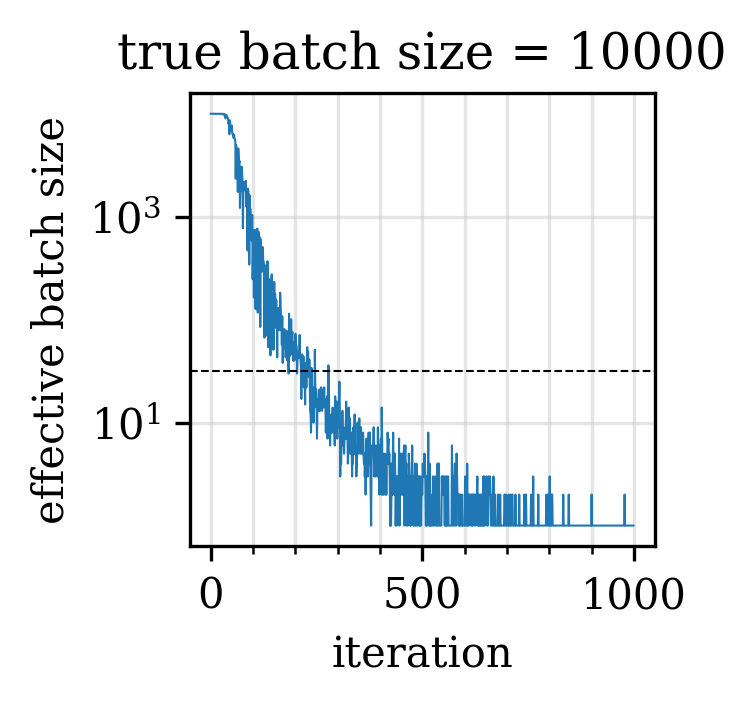

In [122]:
counts = vmap(lambda arg: np.sum(arg > -5))(gfacs_traj)
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(onp.arange(nsteps), counts, lw=0.5)
# ax.axhline(1.0, color='k', lw=0.5, ls='--')
ax.axhline(train_bs, color='k', lw=0.5, ls='--')
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('effective batch size')
ax.set_title('true batch size = 10000')

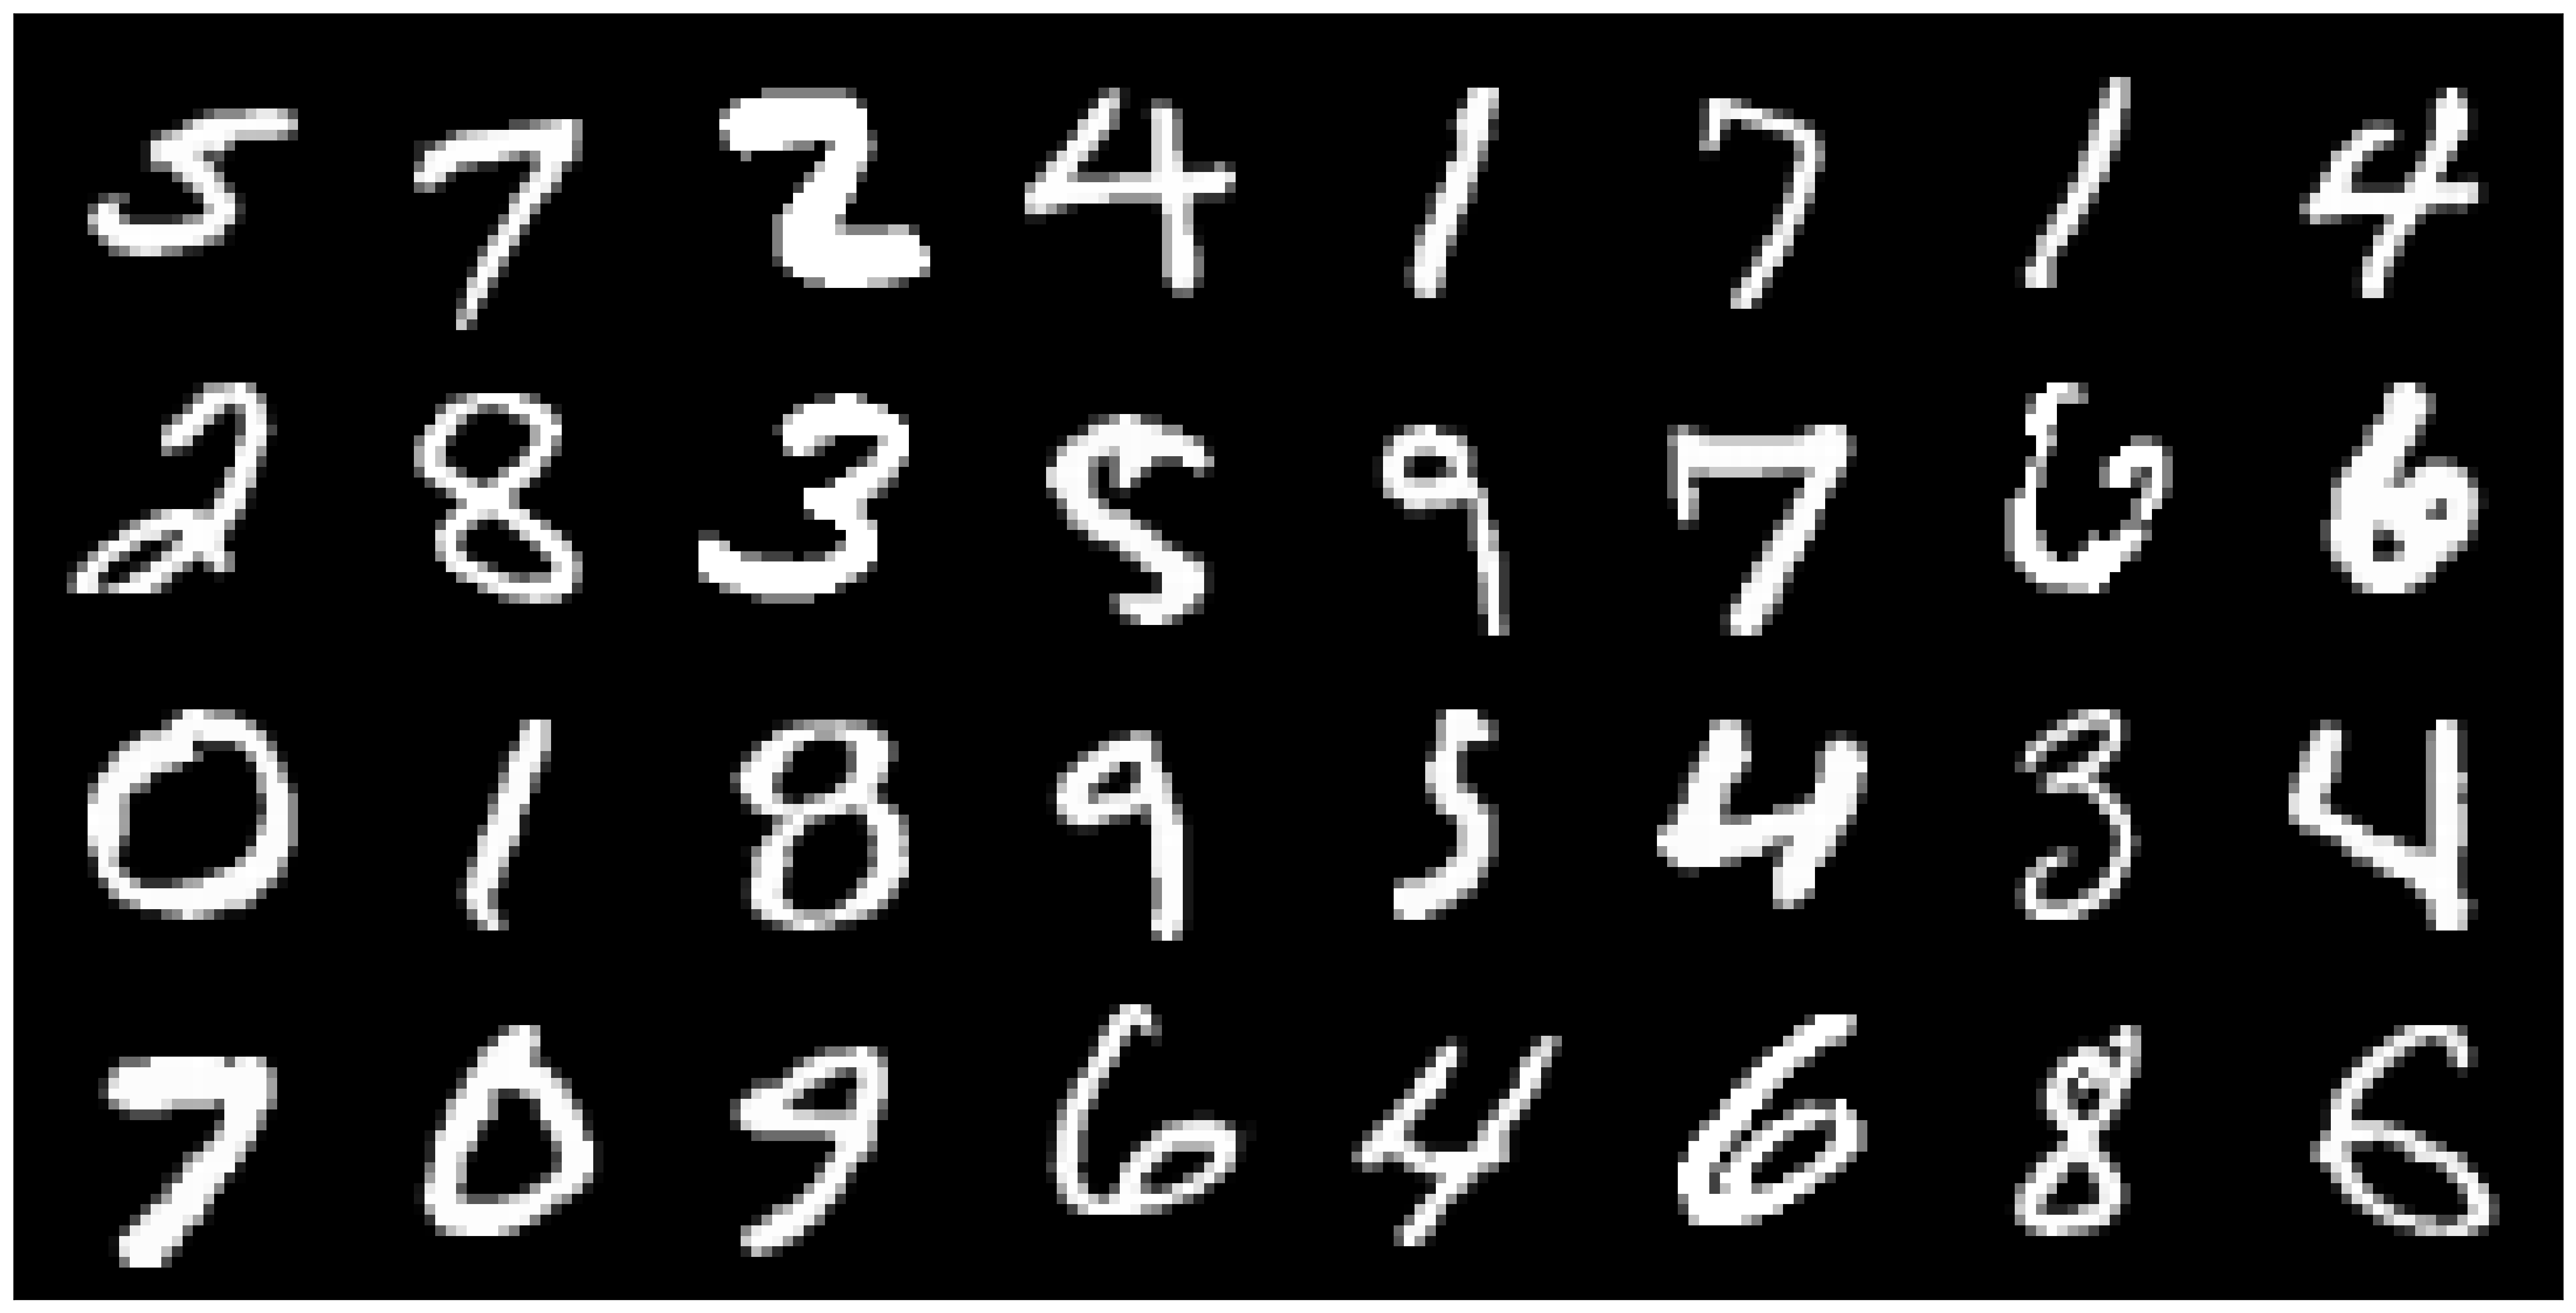

In [214]:
visualize_grid(1, x0s[..., np.newaxis])

### Adaptive Batch Size

In [103]:
def rescale(img: torch.tensor) -> onp.ndarray:
    return (onp.array(img) / 255.0)*2 - 1


def restore(img: np.ndarray):
    return (img + 1.0) / 2.0


train_bs = 32
trainset = datasets.MNIST('/mnt/ceph/users/malbergo/data/', download=True, train=True, transform=rescale)


# train_loader = torch.utils.data.DataLoader(
#     trainset,
#     batch_size=train_bs,
#     shuffle=True
# )

data = torch.zeros((len(trainset),) + (28,28))
print(data.shape)
for i in range(len(trainset)):
    data[i] = torch.tensor(trainset[i][0])

torch.Size([60000, 28, 28])


In [ ]:
example_image = data[i]

/tmp/ipykernel_237964/110335231.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


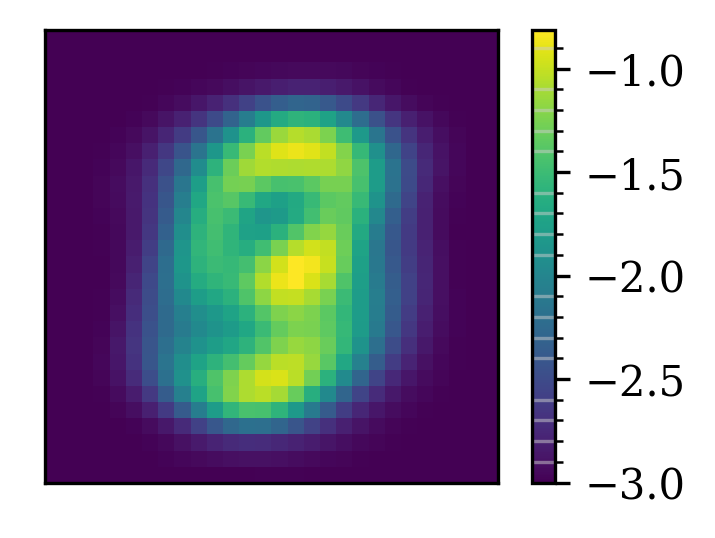

In [119]:
mean_mnist = ((2*data - 1)).mean(0)
fig = plt.figure(figsize=(3,2))
plt.imshow(mean_mnist)
plt.xticks([]), plt.yticks([])
plt.colorbar()

In [192]:
# ts = np.linspace(0,0.99999, nsteps)
# bs = 10
# d = 28*28
# batch_sizes = np.array([int(np.sqrt(d)*(1/(np.sqrt(1 - t)))) for t in ts])
# print(batch_sizes)

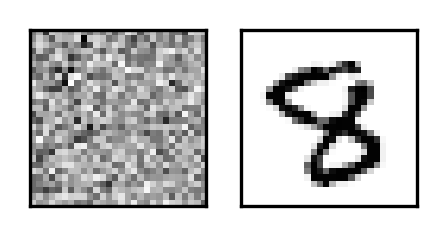

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [191]:
# sampling settings
nsteps    = int(1e3)
delta     = 0
t0        = 0.0
tf        = 1.0 - delta
dt        = (tf - t0) / nsteps
a         = 1.0
alpha     = lambda t: t
alpha_dot = lambda t: 1.0
nu        = 0.5
beta      = lambda t: (a*(1-t))**nu
beta_dot  = lambda t: -a*nu*(a*(1-t))**(nu-1)
bb_dot    = lambda t: -a*nu*(a - a*t)**(2*nu-1)
xt        = lambda t, x0, z: alpha(t)*x0 + beta(t)*z
eps       = 0.0
nprints   = 10
sample_bs = 1
shape     = np.array(next(iter(train_loader))[0]).shape[1:]
fixed_dataset = False


# save trajectories
xs_traj = []
# xs_traj    = onp.zeros((nsteps+1, sample_bs) + shape)
xs         = np.array(onp.random.randn(sample_bs, *shape))
# xs_traj[0] = onp.array(xs)
xs_traj.append(onp.array(xs))
score_traj = []
# score_traj = onp.zeros((nsteps, sample_bs) + shape)
b_traj = []
# b_traj     = onp.zeros((nsteps, sample_bs) + shape)
x0s_traj = []
# x0s_traj   = onp.zeros((nsteps, train_bs) + shape)
x0s        = np.array(next(iter(train_loader))[0])
gfacs_traj = onp.zeros((nsteps, train_bs))


# visualize image trajectories
plt.close('all')
plot_bs = 1
ncols   = 2
fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*250/300, 250/300))
for kk, ax in enumerate(axs):
    if kk == 0:
        axs[kk].imshow(restore(xs[kk] / np.abs(xs[kk]).max()), cmap="Greys")
    else:
        dists = vmap(lambda x0: np.sum((xs[0] - x0)**2))(x0s)
        min_index = np.argmin(dists)
        axs[kk].imshow(restore(x0s[min_index]), cmap="Greys")
    ax.grid(False)
    ax.tick_params(which='both', bottom=False, left=False)
    ax.set_xticks([]); ax.set_yticks([])
plt.pause(0.001)


start_time = time.time()
for curr_step in range(nsteps):
    # set up current time
    t = t0 + (curr_step + 0.5)*dt


    # sample from the target and draw noises for the SDE
    if not fixed_dataset:
        x0s    = np.array(next(iter(train_loader))[0])

    key    = jax.random.split(key)[0]
    noises = jax.random.normal(key, shape)
    
    # take a step
    bs, scores, us, gfacs = batch_eval_drifts(t, xs, x0s, alpha, beta, alpha_dot, beta_dot, bb_dot)
    expt                  = np.exp(dt*beta_dot(t) / beta(t))
    iexpt                 = (expt - 1)*beta(t) / beta_dot(t)
    siexpt                = 0.5*(expt**2 - 1)*beta(t) / beta_dot(t)
    xs                    = xs*expt + iexpt*us*(alpha_dot(t) - alpha(t)*beta_dot(t)/beta(t)) + iexpt*eps*scores + np.sqrt(2*eps*siexpt)*noises
#     xs             = xs + dt*(bs + eps*scores) + np.sqrt(2*eps*dt)*noises

    
    # save trajectories
    x0s_traj.append(onp.array(x0s))
    xs_traj.append(onp.array(xs))
    score_traj.append(onp.array(scores))
    b_traj.append(onp.array(bs + eps*scores))
    gfacs_traj.append(onp.squeeze(gfacs))
    # x0s_traj[curr_step]   = onp.array(x0s)
    # xs_traj[curr_step+1]  = onp.array(xs)
    # score_traj[curr_step] = onp.array(scores)
    # b_traj[curr_step]     = onp.array(bs + eps*scores)
    # gfacs_traj[curr_step] = onp.array(onp.squeeze(gfacs))


    if (curr_step + 1) % (nsteps // nprints) == 0:
        end_time = time.time()
        print(f'Finished step={curr_step+1}. Time={end_time-start_time}s. t={t}.')
        start_time = time.time()

        plt.close('all')
        fig, axs = plt.subplots(ncols=1+plot_bs, figsize=(ncols*250/300, 250/300))
        for kk, ax in enumerate(axs):
            if kk == 0:
                axs[kk].imshow(restore(xs[kk] / np.abs(xs[kk]).max()), cmap="Greys")
            else:
                dists = vmap(lambda x0: np.sum((xs[0] - x0)**2))(x0s)
                min_index = np.argmin(dists)
                axs[kk].imshow(restore(x0s[min_index]), cmap="Greys")
            ax.grid(False)
            ax.tick_params(which='both', bottom=False, left=False)
            ax.set_xticks([]); ax.set_yticks([])
        plt.pause(0.001)

# Mirror Interpolant

In [3]:
# @partial(jit, static_argnums=3)
# def gaussian_fac(
#     t: float,
#     x: np.ndarray, 
#     x0: np.ndarray,
#     gamma: Callable[[float], float]
# ) -> np.ndarray:
#     norm = np.sum((x-x0)**2)
#     var  = 2*gamma(t)**2
#     return np.exp(-norm/var)


# @partial(jit, static_argnums=3)
# def eval_score(
#     t: float,
#     x: np.ndarray,
#     x0s: np.ndarray,
#     gamma: Callable[[float], float]
# ) -> np.ndarray:
#     gfacs = vmap(lambda x0: gaussian_fac(t, x, x0, gamma))(x0s)
#     gfacs = gfacs / np.mean(gfacs)
#     return -np.mean(vmap(lambda x0, gfac: gfac*(x-x0)/gamma(t)**2)(x0s, gfacs), axis=0)


@partial(jit, static_argnums=3)
def gaussian_fac(
    t: float,
    x: np.ndarray, 
    x0: np.ndarray,
    gamma: Callable[[float], float]
) -> np.ndarray:
    norm = np.sum((x-x0)**2)
    var  = 2*gamma(t)**2
    return -norm/var


@partial(jit, static_argnums=3)
def eval_score(
    t: float,
    x: np.ndarray,
    x0s: np.ndarray,
    gamma: Callable[[float], float]
) -> np.ndarray:
    gfacs = vmap(lambda x0: gaussian_fac(t, x, x0, gamma))(x0s)
    gfacs = np.exp(gfacs - gfacs.max())
    gfacs = gfacs / np.mean(gfacs)
    return -np.mean(vmap(lambda x0, gfac: gfac*(x-x0)/gamma(t)**2)(x0s, gfacs), axis=0)


batch_eval_score = vmap(eval_score, in_axes=(None, 0, None, None))

## N(0, 1)

In [3]:
nsteps    = int(1e3)
t0        = 0
tf        = 1.0
dt        = (tf - t0) / nsteps
a         = 10.0
gamma     = lambda t: np.sqrt(a*t*(1-t))
gg_dot    = lambda t: 0.5*a*(1 - 2*t)
eps       = 2.5
sample_bs = 4096
target_bs = 4096
d         = 1
nprints   = 10


def sample_target(key: np.ndarray, n_samples: int):
    return jax.random.normal(key, (n_samples, d))


xs_traj    = onp.zeros((nsteps+1, sample_bs, d))
key        = jax.random.split(key)[0]
xs         = sample_target(key, sample_bs)
xs_traj[0] = onp.array(xs)


start_time = time.time()
for curr_step in range(nsteps):
    # set up current time
    t = t0 + (curr_step + 0.5)*dt


    # sample from the target and draw noises for the SDE
    key     = jax.random.split(key)[0]
    x0s     = sample_target(key, target_bs)
    key     = jax.random.split(key)[0]
    noises  = jax.random.normal(key, shape=xs.shape)
    
    
    # take a step
    scores               = batch_eval_score(t, xs, x0s, gamma)
    xs                   = xs + dt*(eps - gg_dot(t))*scores + np.sqrt(2*eps*dt)*noises
    xs_traj[curr_step+1] = onp.array(xs)


    if (curr_step + 1) % (nsteps // nprints) == 0:
        end_time = time.time()
        print(f'Finished step={curr_step+1}. Time={end_time-start_time}s. t={t}.')
        start_time = time.time()

Finished step=100. Time=0.9864449501037598s. t=0.0995.
Finished step=200. Time=0.3970487117767334s. t=0.1995.
Finished step=300. Time=0.3916661739349365s. t=0.2995.
Finished step=400. Time=0.39086341857910156s. t=0.3995.
Finished step=500. Time=0.39383363723754883s. t=0.4995.
Finished step=600. Time=0.3862781524658203s. t=0.5995.
Finished step=700. Time=0.3887608051300049s. t=0.6995.
Finished step=800. Time=0.3858470916748047s. t=0.7995.
Finished step=900. Time=0.3855326175689697s. t=0.8995.
Finished step=1000. Time=0.38985395431518555s. t=0.9995.


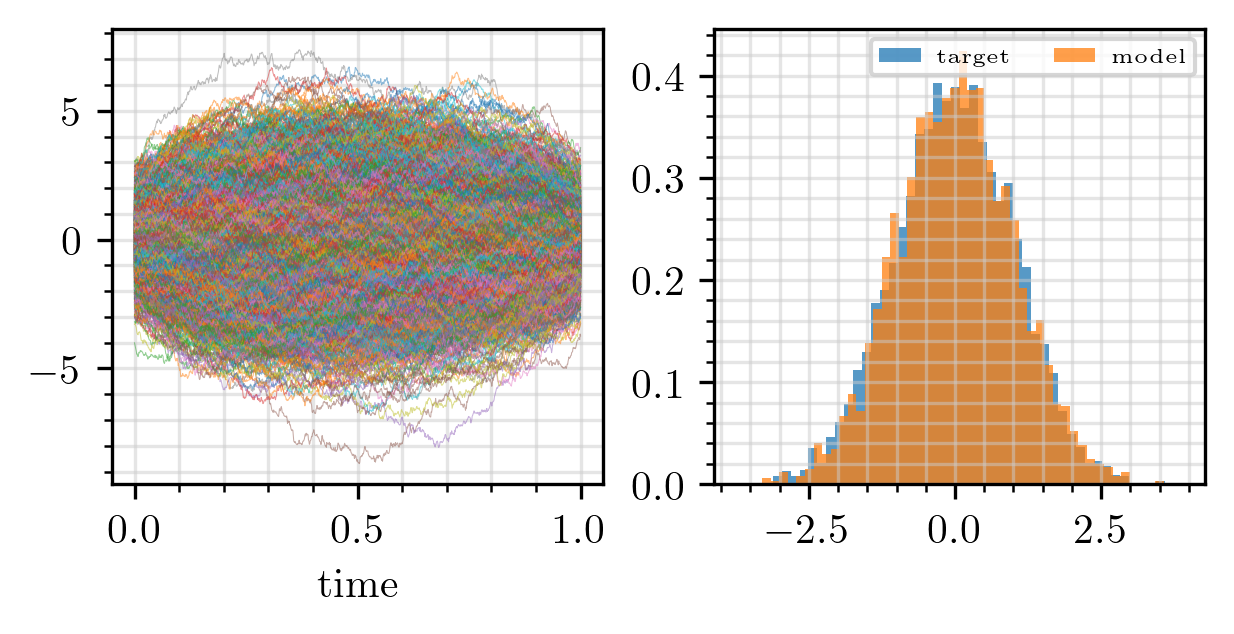

In [4]:
plt.close('all')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), constrained_layout=True)
ts       = onp.linspace(t0, tf, nsteps+1)


axs[0].plot(ts, onp.squeeze(xs_traj), alpha=0.5, lw=0.25)
axs[0].set_xlabel('time')
_ = axs[1].hist(onp.squeeze(x0s), bins=50, alpha=0.75, label='target', density=True)
_ = axs[1].hist(onp.squeeze(xs), bins=50, alpha=0.75,  label='model', density=True)
axs[1].legend(ncol=2, fontsize=5.0)

## Cifar-10

In [4]:
def rescale(img: torch.tensor) -> onp.ndarray:
#     return 2*(onp.array(img)/255.0 - 0.5)
    return (onp.array(img) / 255.0)*2 - 1


def restore(img: np.ndarray):
    return (img + 1.0) / 2.0


train_bs = 1024
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('/scratch/nb3397/datasets', download=True, train=True, transform=rescale),
    batch_size=train_bs,
    shuffle=True
)


sample_bs = 1
sample_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('/scratch/nb3397/datasets', download=True, train=False, transform=rescale), 
    batch_size=sample_bs, 
    shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


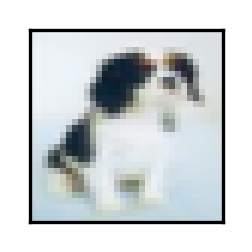

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished step=100. Time=13.107305526733398s. t=0.0995.


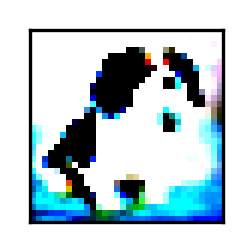

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished step=200. Time=12.754378318786621s. t=0.1995.


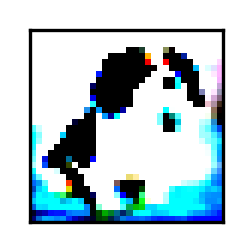

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished step=300. Time=12.82171106338501s. t=0.2995.


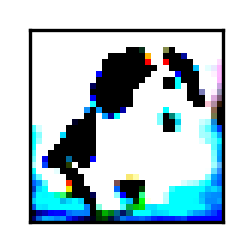

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished step=400. Time=12.706262111663818s. t=0.3995.


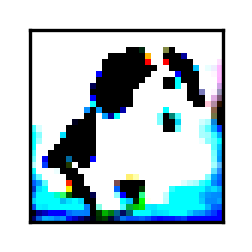

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished step=500. Time=12.799333810806274s. t=0.4995.


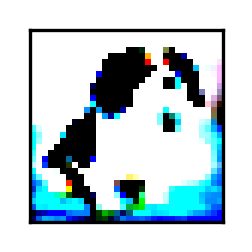

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished step=600. Time=12.428571462631226s. t=0.5995.


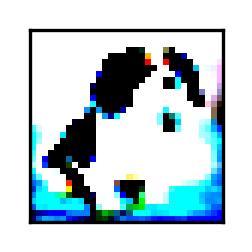

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished step=700. Time=12.392226696014404s. t=0.6995.


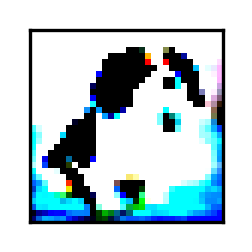

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished step=800. Time=12.177988767623901s. t=0.7995.


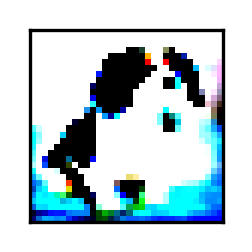

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Finished step=900. Time=12.149155616760254s. t=0.8995.


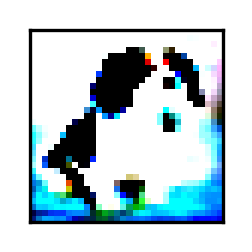

Finished step=1000. Time=12.003696918487549s. t=0.9995.


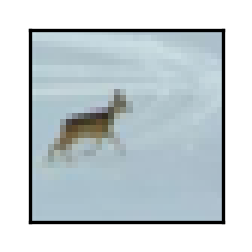

In [27]:
# sampling settings
nsteps  = int(1e3)
t0      = 0
tf      = 1.0 - t0
dt      = (tf - t0) / nsteps
a       = 1e4
gamma   = lambda t: np.sqrt(a*t*(1-t))
gg_dot  = lambda t: 0.5*a*(1 - 2*t)
eps     = 0.0
nprints = int(1e1)


# save trajectories
xs         = np.array(next(iter(sample_loader))[0])
shape      = xs.shape
xs_traj    = onp.zeros((nsteps+1,) + shape)
xs_traj[0] = onp.array(xs)
score_traj = onp.zeros((nsteps,) + shape)
b_traj     = onp.zeros((nsteps,) + shape)
x0s_traj   = onp.zeros((nsteps, train_bs) + shape[1:])


# visualize image trajectories
plt.close('all')
fig, ax = plt.subplots(figsize=(250/300, 250/300))
ax.imshow(restore(xs[0]))
ax.grid(False)
ax.tick_params(which='both', bottom=False, left=False)
ax.set_xticks([]); ax.set_yticks([])
plt.pause(0.001)


start_time = time.time()
for curr_step in range(nsteps):
    # set up current time
    t = t0 + (curr_step + 0.5)*dt


    # sample from the target and draw noises for the SDE
    x0s                 = np.array(next(iter(train_loader))[0])
    key                 = jax.random.split(key)[0]
    noises              = jax.random.normal(key, shape)
    
    # take a step
    scores                = batch_eval_score(t, xs, x0s, gamma)
    xs                    = xs + dt*(eps - gg_dot(t))*scores + np.sqrt(2*eps*dt)*noises
    
    # save trajectories
    x0s_traj[curr_step]   = onp.array(x0s)
    xs_traj[curr_step+1]  = onp.array(xs)
    score_traj[curr_step] = onp.array(scores)
    b_traj[curr_step]     = onp.array(-gg_dot(t)*scores)


    if (curr_step + 1) % (nsteps // nprints) == 0:
        end_time = time.time()
        print(f'Finished step={curr_step+1}. Time={end_time-start_time}s. t={t}.')
        start_time = time.time()


        plt.close('all')
        fig, ax = plt.subplots(figsize=(250/300, 250/300))
        restored_image = restore(xs[0])
        ax.imshow(restored_image)
        ax.grid(False)
        ax.tick_params(which='both', bottom=False, left=False)
        ax.set_xticks([]); ax.set_yticks([])
        plt.pause(0.001)

[]

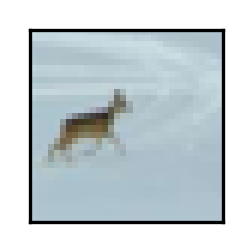

In [30]:
dists     = vmap(lambda x0: np.sum((xs_traj[-1][0] - x0)**2))(x0s_traj[-1])
min_index = np.argmin(dists)
fig, ax   = plt.subplots(figsize=(250/300, 250/300))
ax.imshow(restore(x0s[min_index]))
ax.grid(False)
ax.tick_params(which='both', bottom=False, left=False)
ax.set_xticks([]); ax.set_yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


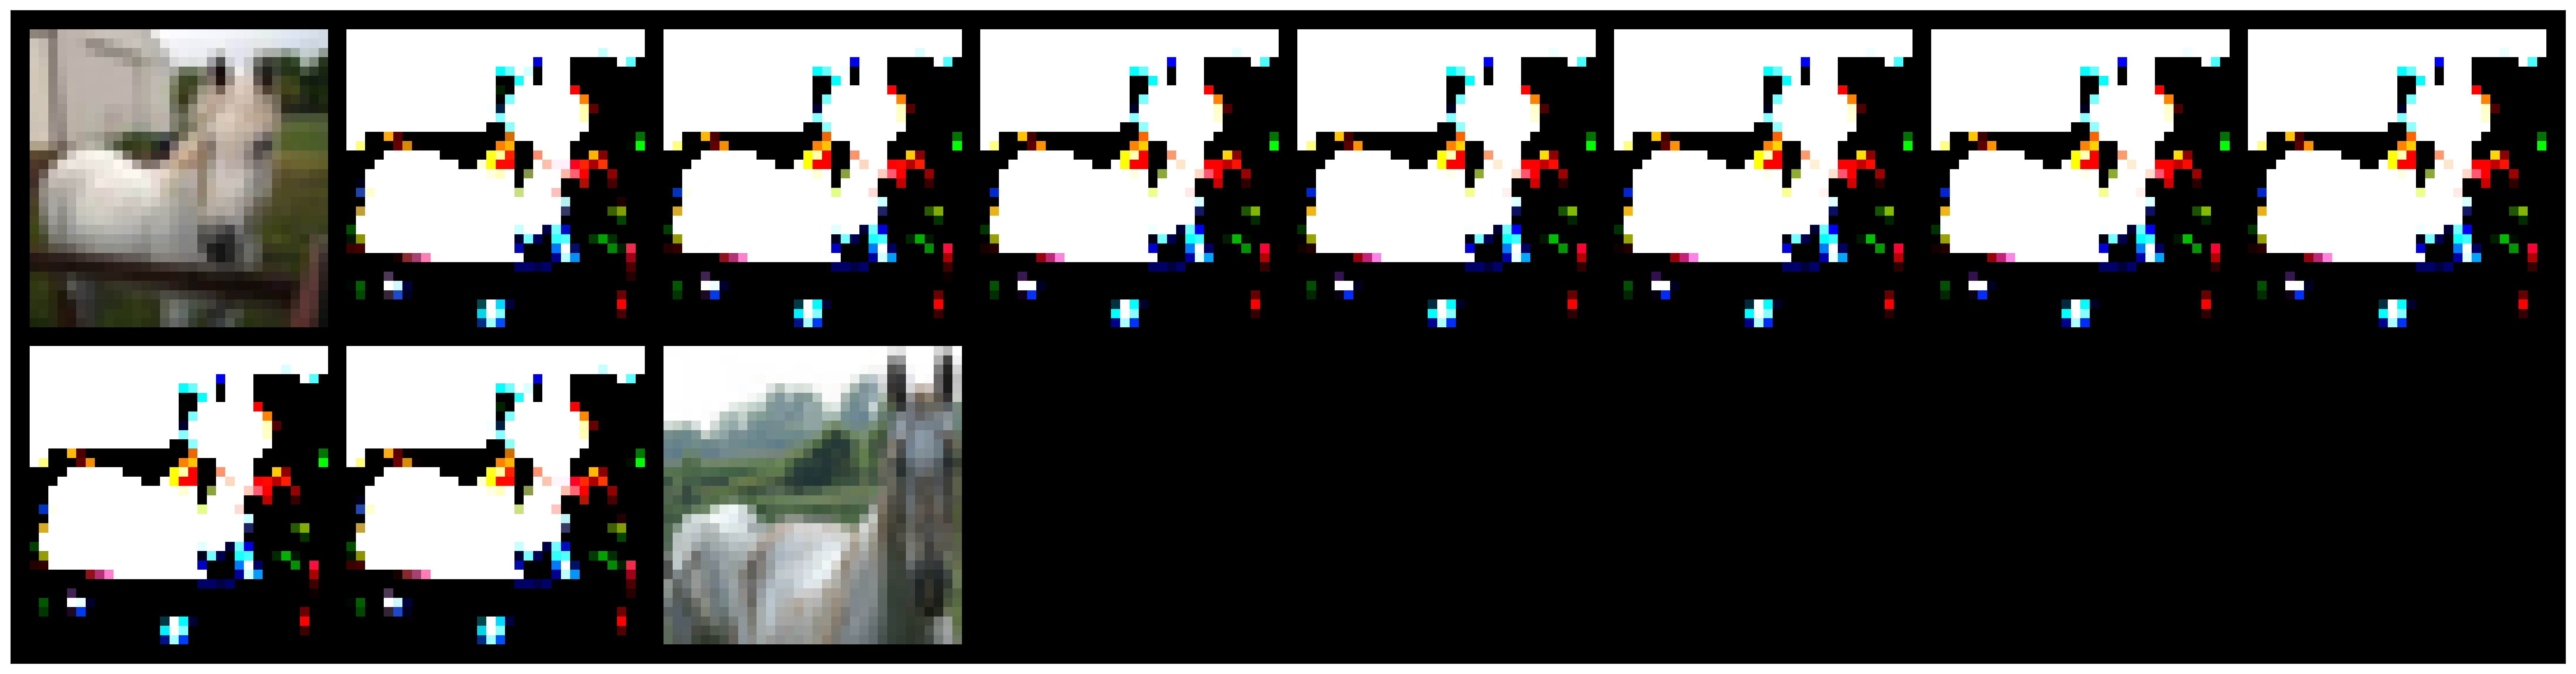

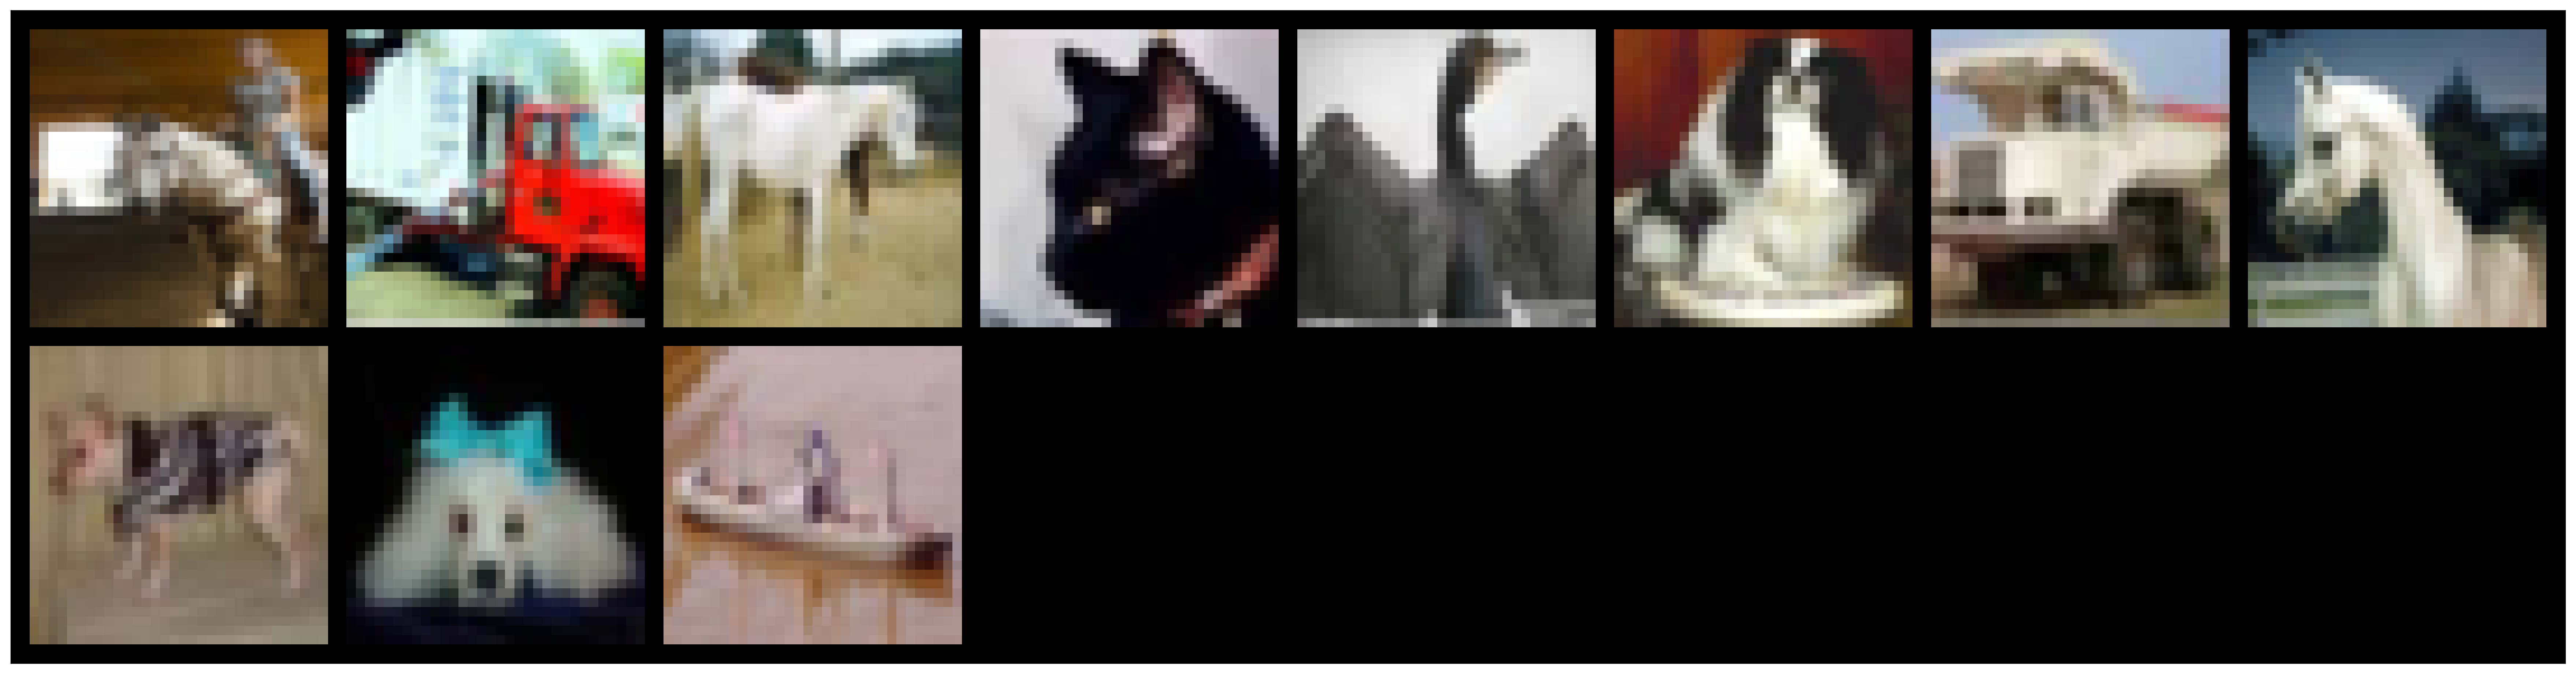

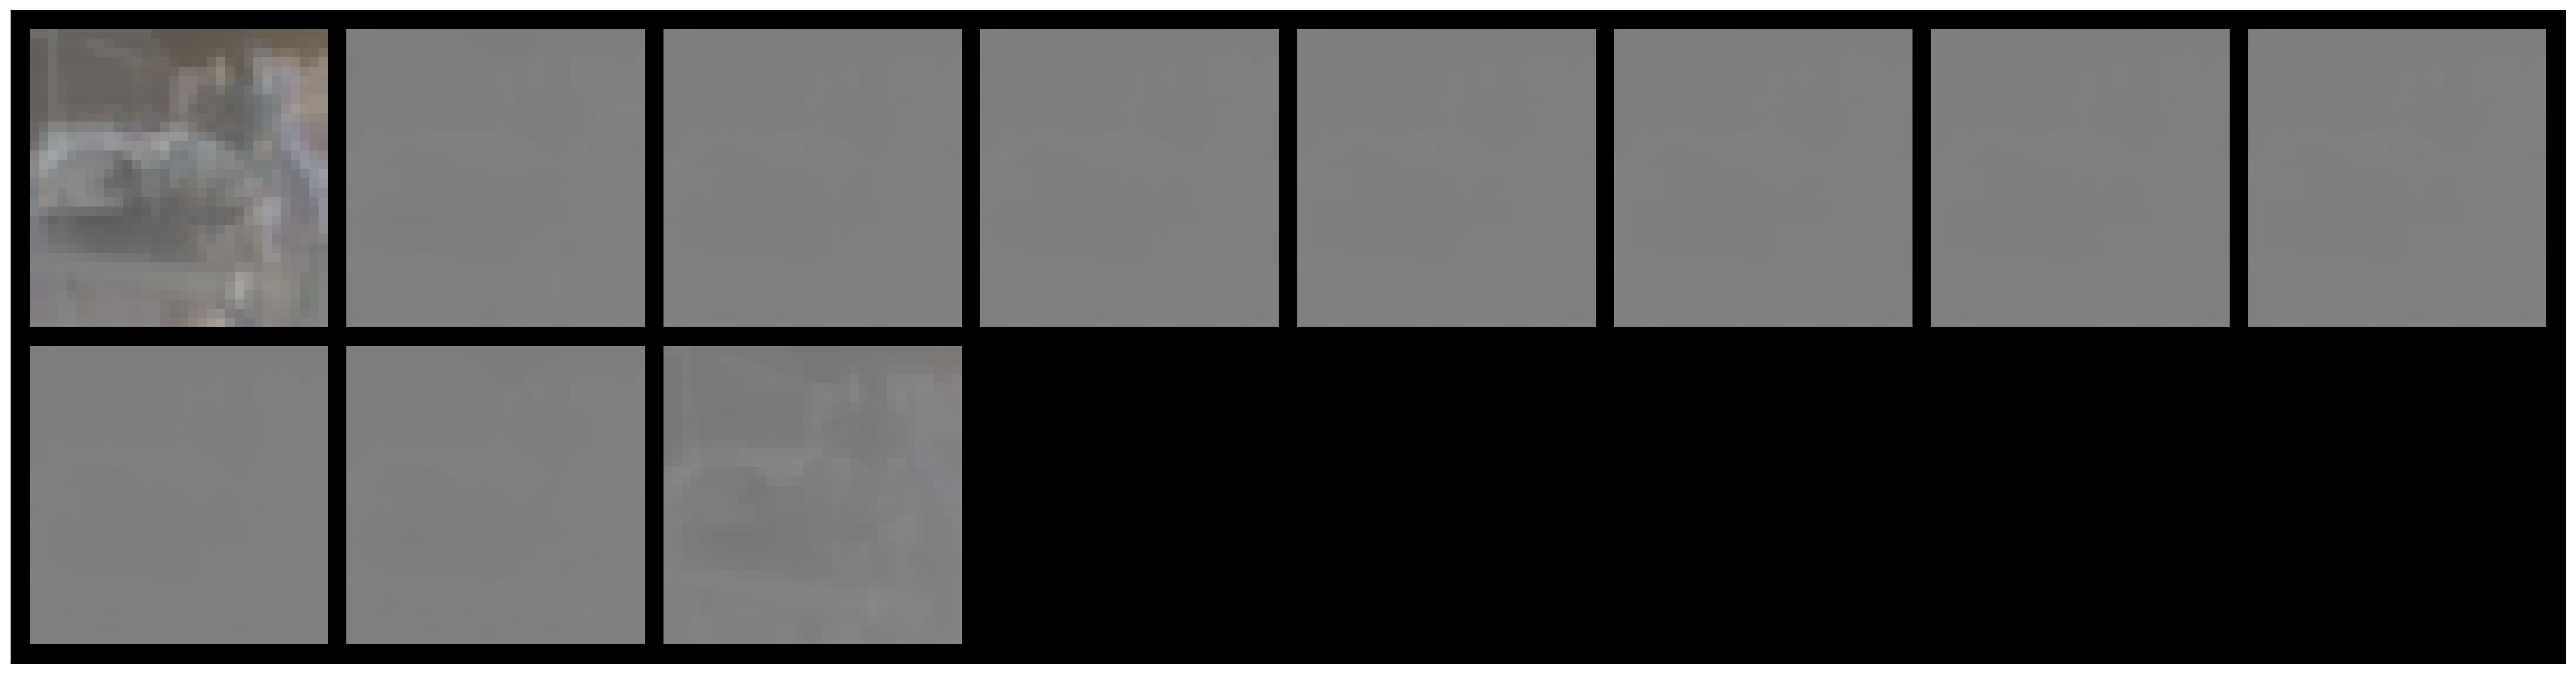

In [19]:
visualize_traj(100, xs_traj)
visualize_traj(99, x0s_traj)
visualize_traj(99, dt*score_traj)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


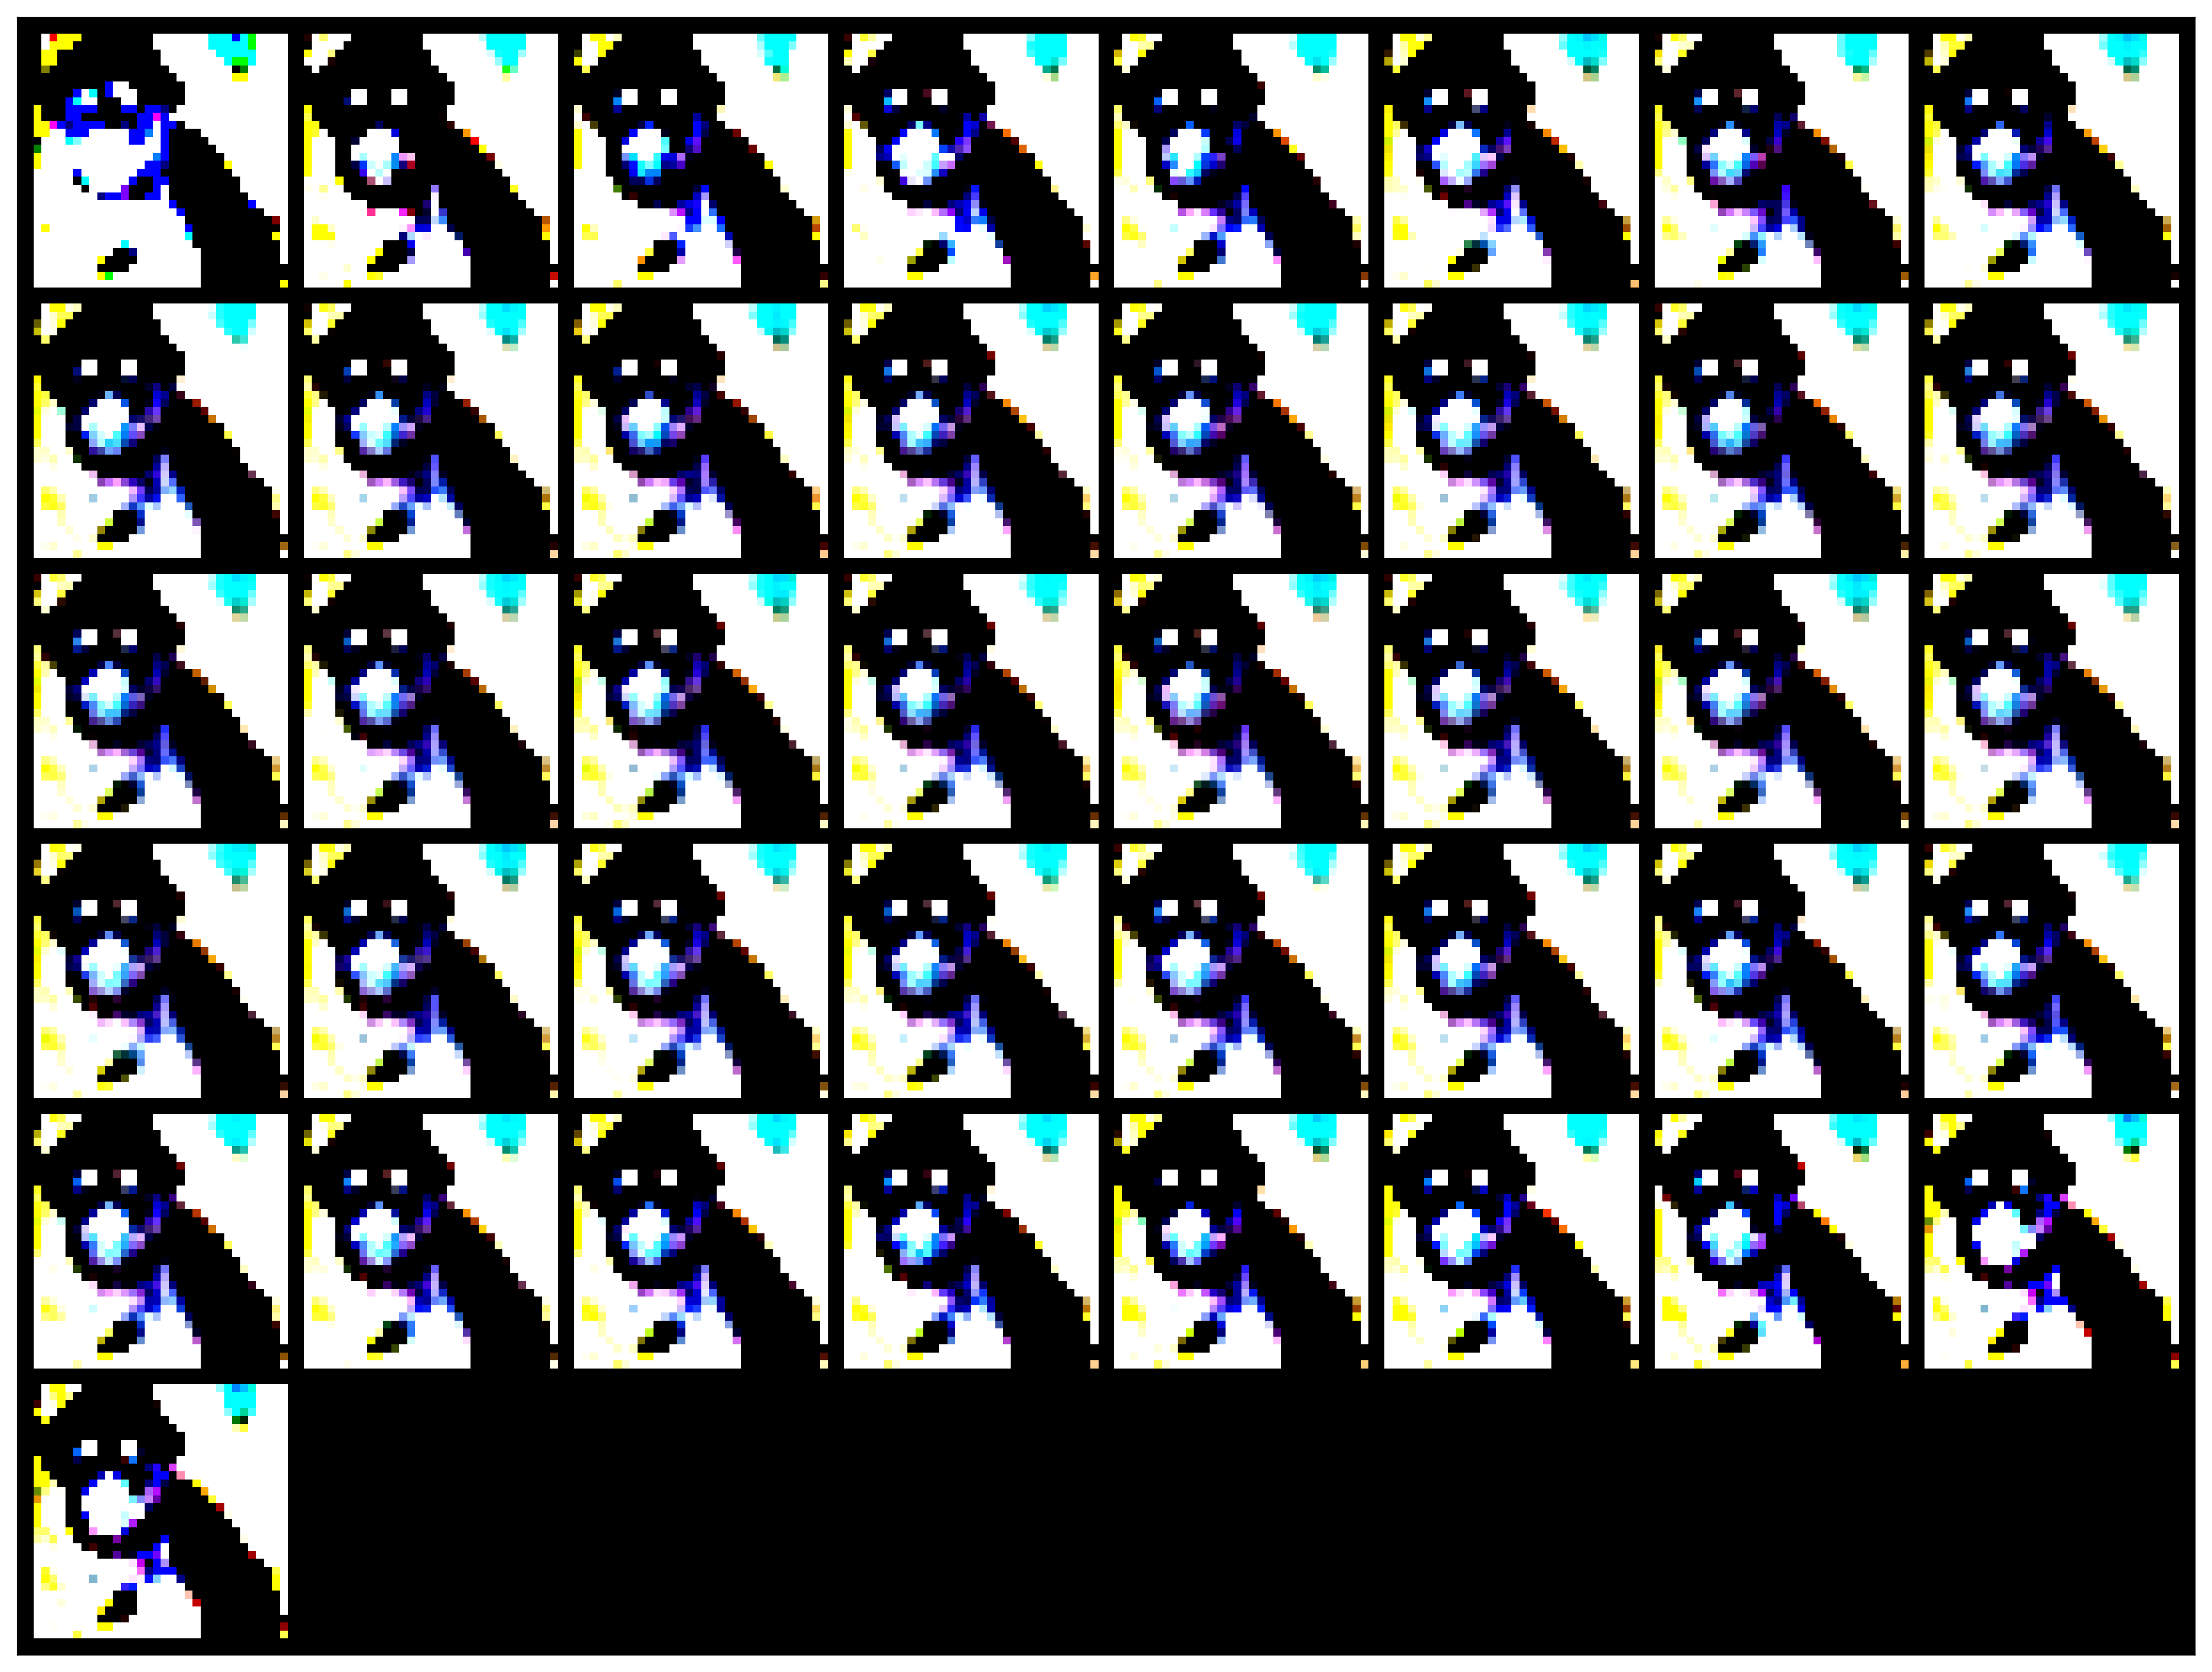

In [235]:
visualize_traj(25, score_traj)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


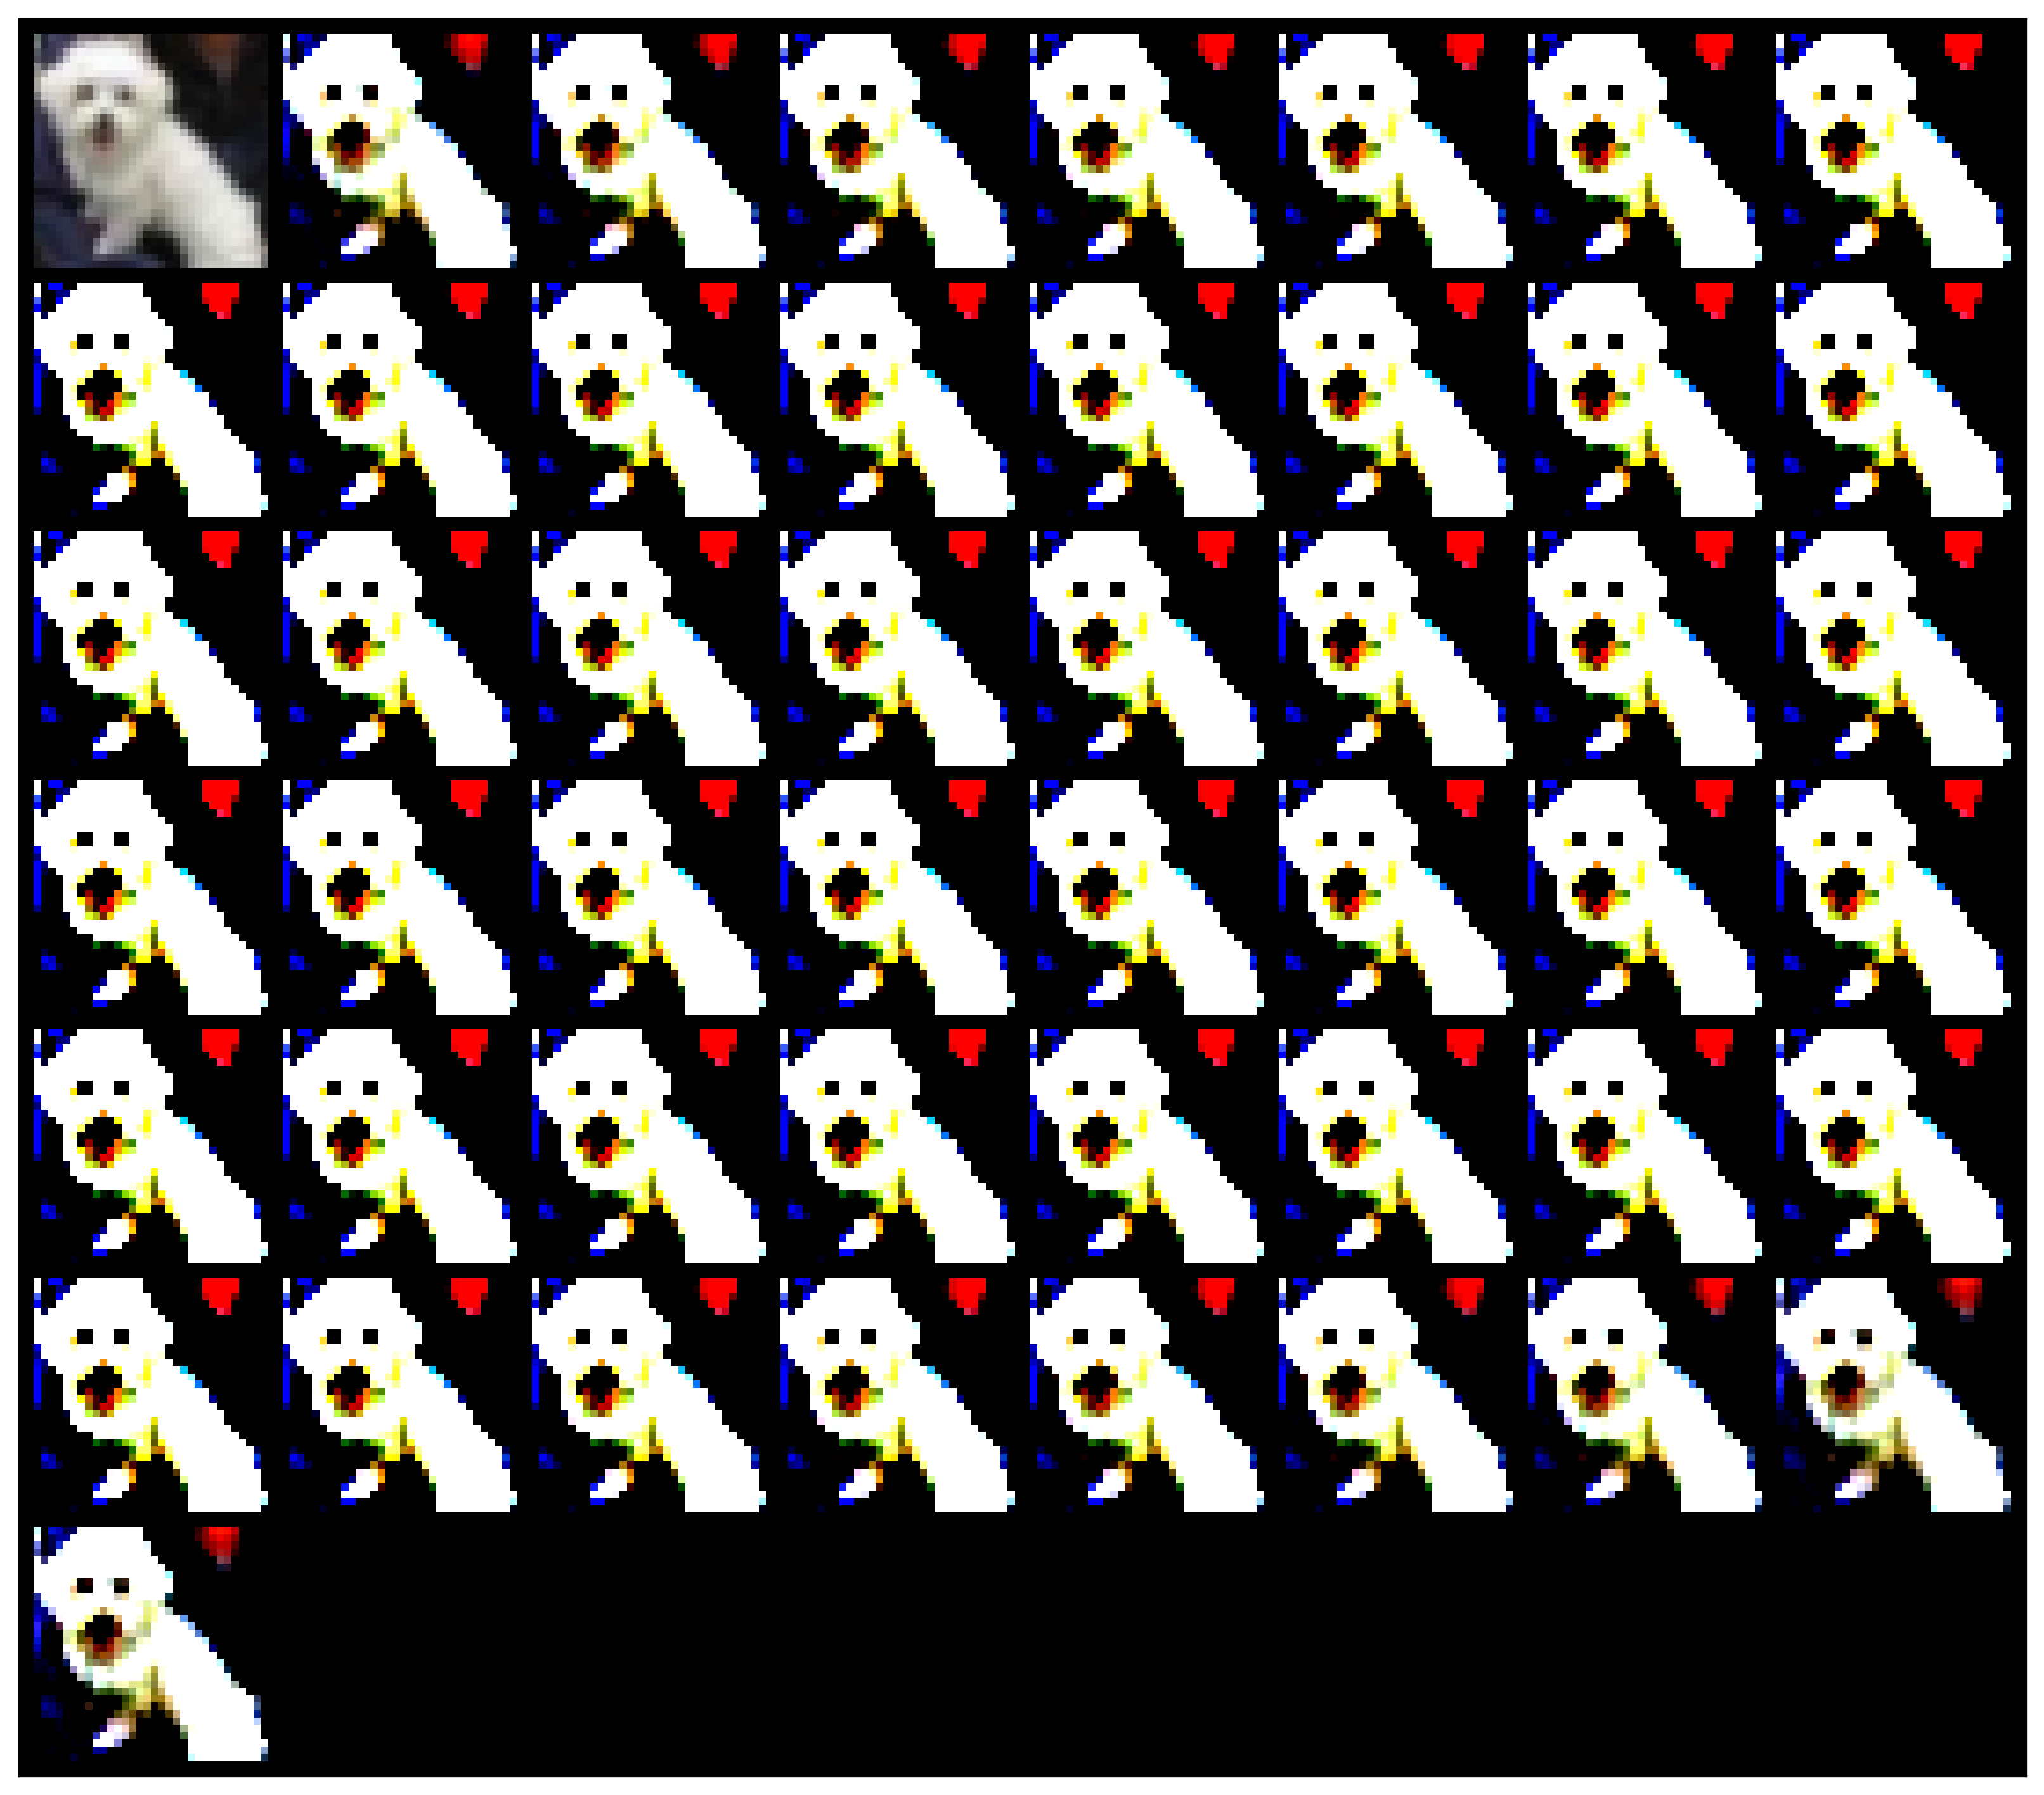

In [240]:
visualize_traj(21, xs_traj)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


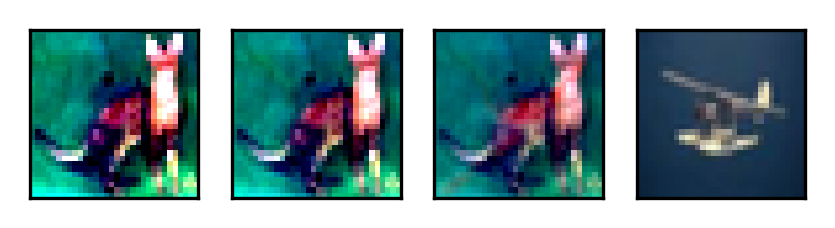

In [209]:
plt.close('all')
fig, axs = plt.subplots(ncols=4, figsize=(1000/300, 250/300))


axs[0].imshow(restore(xs_traj[-4][0]))
axs[1].imshow(restore(xs_traj[-3][0]))
axs[2].imshow(restore(xs_traj[-2][0]))
axs[3].imshow(restore(xs_traj[-1][0]))

for ax in axs:
    ax.grid(False)
    ax.tick_params(which='both', bottom=False, left=False)
    ax.set_xticks([]); ax.set_yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

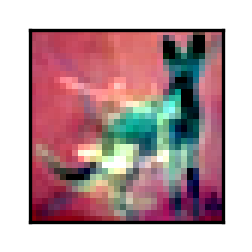

In [223]:
plt.close('all')
fig, ax = plt.subplots(figsize=(250/300, 250/300))


ax.imshow(restore(-dt*gg_dot(1.0-dt)*scores[0]))
ax.grid(False)
ax.tick_params(which='both', bottom=False, left=False)
ax.set_xticks([]); ax.set_yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

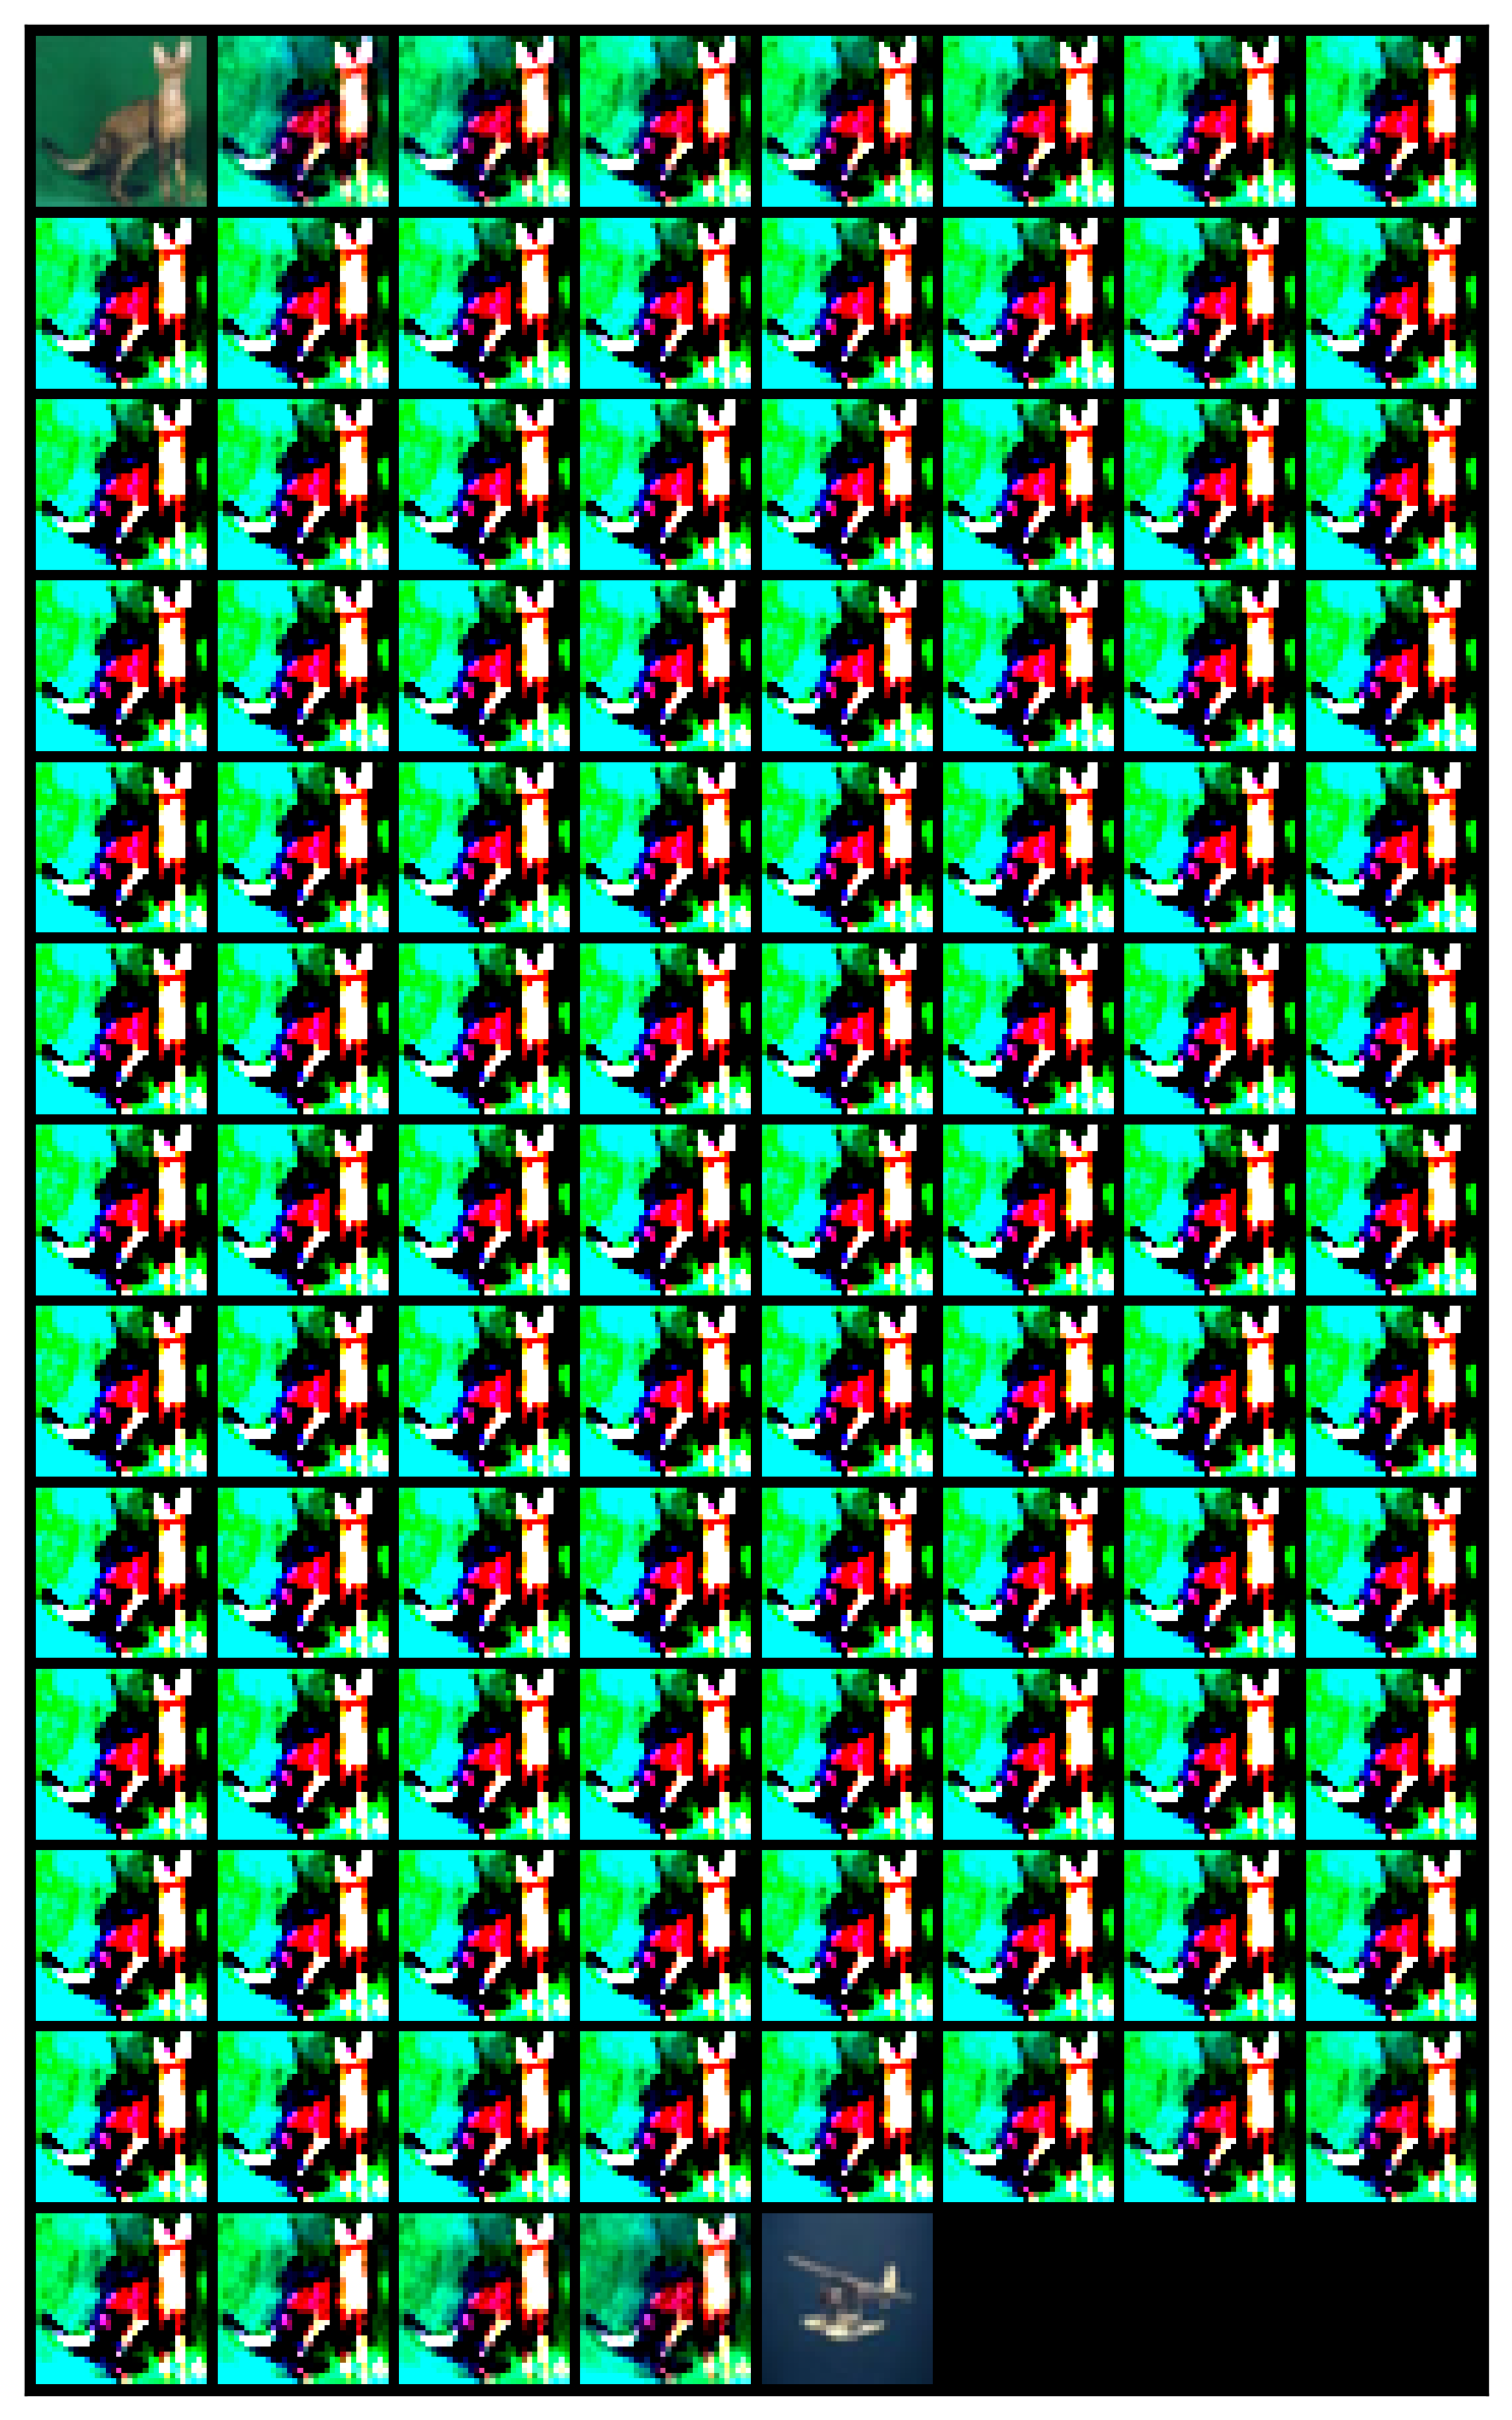

In [227]:
normed_traj = list(torch.tensor(onp.array(vmap(restore)(xs_traj))))[::10]
norm_grid = torchvision.utils.make_grid([normed_x[0].permute(2, 0, 1) for normed_x in normed_traj])
fig = plt.figure(figsize=(30,12))
plt.imshow(norm_grid.permute(1, 2, 0))
plt.xticks([]); plt.yticks([])

In [ ]:
normed_x0s = list(torch.tensor(onp.array(vmap(restore)(x0s))))
norm_grid = torchvision.utils.make_grid([normed_x0.permute(2, 0, 1) for normed_x0 in normed_x0s])
fig = plt.figure(figsize=(30,12))
plt.imshow(norm_grid.permute(1, 2, 0))
plt.xticks([]); plt.yticks([])